# **生体信号を使用した喫煙者の状態のバイナリ予測**
(Binary Prediction of Smoker Status using Bio-Signals)

# 参考資料
**書籍**
- Pythonで学ぶビジネスデータの予測モデル
- 東京大学のデータサイエンティスト育成講座 Pythonで手を動かして学ぶデ―タ分析

**Kaggle**
- [PS_3.24_LGBM_bin_日本語あり](https://www.kaggle.com/code/akioonodera/ps-3-24-lgbm-bin)
- [PS-S3-Ep24 | EDA 📊 | Modeling + Submission 🚀](https://www.kaggle.com/code/oscarm524/ps-s3-ep24-eda-modeling-submission)
- [PS3E24 | EDA | Feature Engineering | Ensemble](https://www.kaggle.com/code/arunklenin/ps3e24-eda-feature-engineering-ensemble)

**記事**

**自分で作成したファイル**
- モース硬度データセットを使用した回帰

## 概要
1. 目的：健診データから喫煙者か否かを予測する
2. タスクの種類：二値分類の課題

- **問題声明: 喫煙者の禁煙を予測する**
    - 喫煙は世界中で予防可能な疾患や死亡の主要な要因であり、2030年までに喫煙関連の死亡者は1000万人に達する見込み。
    - 現在の喫煙者の禁煙効果は低く、喫煙禁止に影響を与える要因が複雑であるため。
- **目標**
    - 機械学習（ML）を使用して、生体信号を基に個人の喫煙状態を予測するモデルの構築。
    - ニコチン依存症、一酸化炭素レベル、1日の喫煙本数、喫煙開始年齢、以前の禁煙試行、精神的な幸福感、人格特性、禁煙への意欲など、さまざまな要因を考慮。
    - 予測モデルを開発し、医療専門家や患者が喫煙を成功裏にやめる可能性を理解する手助けをする。

前回に引き続き二値分類の課題ですので、Objectiveとしてbinary、Metricとしてbinary_loglossを使います。与えられたデータには欠損値もありませんし、整数または小数値なので、一旦はそのまま処理していきます（0/1および1/2で分類されているものもありますので、後でここに手を加えるかもしれません）。トレーニングデータに一部外れ値らしきものがありますので、これだけは除外しようと思います。

### 各特徴量の日本語訳
#### Japanese
'age' : 年齢<br>
'height(cm)' : 身長（cm）<br>
'weight(kg)' : 体重（kg）<br>
'waist(cm)' : 腹囲（cm）<br>
'eyesight(left)' : 視力（左）<br>
'eyesight(right)' : 視力（右）<br>
'hearing(left)' : 聴力（左）<br>
'hearing(right)' : 聴力（右）<br>
'systolic' : 最高血圧<br>
'relaxation' : 最低血圧<br>
'fasting blood sugar' : 空腹時血糖値<br>
'Cholesterol' : コレステロール<br>
'triglyceride', : 中性脂肪<br>
'HDL' : 善玉コレステロール<br>
'LDL' : 悪玉コレステロール<br>
'hemoglobin' : ヘモグロビン<br>
'Urine protein' : 尿蛋白<br>
'serum creatinine' : 血清クレアチニン<br>
'AST' : アスパラギン酸アミノトランスフェラーゼ（肝機能）<br>
'ALT' : アラニンアミノ基転移酵素（肝機能）<br>
'Gtp' : ガンマGTP<br>
'dental caries' : 虫歯<br>
'smoking' : 喫煙

#### 評価指標：　Area Under the ROC Curve(AUC)
- ROC曲線に基づくモデルの評価指標
- ROC曲線と横軸で囲まれる面積の値
- 大小比較を行い相対的な順番を与える
- 不均衡データ（imbalanced data）下におけるモデルの評価時にも耐えられる指標

# ライブラリ・データセットのインポート

In [2]:
import pandas as pd
import numpy as np
from scipy import stats
from scipy.stats import norm, skew

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
from IPython.display import display
import sweetviz as sv

import warnings; warnings.filterwarnings("ignore")

# pd.set_option('display.max_columns', 30)
pd.options.display.max_columns = 30
pd.options.display.max_rows = 50
plt.style.use('ggplot')

In [3]:
from sklearn.ensemble import RandomForestRegressor
import missingno as msno

## 実行時間を調べるために使う

In [4]:
import datetime
import time
import math

start_time = time.time()

def changeHMS(s):
    h = math.floor(s / 3600)
    if h > 0:
        s = s - h * 3600
        indi_h = str(h) + 'h'
    else:
        indi_h = ''
    m = math.floor(s / 60)
    if m > 0:
        indi_m = str(m) + 'm'
    else:
        indi_m = ''
    s = math.floor(s % 60)
    time = indi_h + indi_m + str(s) + 's'
    return time

In [5]:
FILE_PATH = '/Users/ootsuka/Desktop/プログラミング/Kaggle/生体信号を使用した喫煙者の状態のバイナリ予測/'
OUTPUT_DIR = '/Users/ootsuka/Desktop/プログラミング/Kaggle/生体信号を使用した喫煙者の状態のバイナリ予測/output/'
train = pd.read_csv(FILE_PATH + 'input/train.csv')
test = pd.read_csv(FILE_PATH + 'input/test.csv')

## id と目的変数（smoking）の分割

In [6]:
train_id = train['id']
train.drop('id', axis=1, inplace=True)

test_id = test['id']
test.drop('id', axis=1, inplace=True)

target = train['smoking']
target_name = str(train.iloc[:, [22]].columns.tolist())

## データ(DataFrame)の構成を調べる

In [7]:
train.head()

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  \
0   55         165          60       81.0             0.5              0.6   
1   70         165          65       89.0             0.6              0.7   
2   20         170          75       81.0             0.4              0.5   
3   35         180          95      105.0             1.5              1.2   
4   30         165          60       80.5             1.5              1.0   

   hearing(left)  hearing(right)  systolic  relaxation  fasting blood sugar  \
0              1               1       135          87                   94   
1              2               2       146          83                  147   
2              1               1       118          75                   79   
3              1               1       131          88                   91   
4              1               1       121          76                   91   

   Cholesterol  triglyceride  HDL  LDL  hemoglobin  Urine protein  \
0          172           300   40   75        16.5              1   
1          194            55   57  126        16.2              1   
2          178           197   45   93        17.4              1   
3          180           203   38  102        15.9              1   
4          155            87   44   93        15.4              1   

   serum creatinine  AST  ALT  Gtp  dental caries  smoking  
0               1.0   22   25   27              0        1  
1               1.1   27   23   37              1        0  
2               0.8   27   31   53              0        1  
3               1.0   20   27   30              1        0  
4               0.8   19   13   17              0        1

In [8]:
test.head()

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  eyesight(right)  \
0   40         165          70       84.0             1.2              1.2   
1   80         160          60       93.0             1.0              1.0   
2   60         170          70       86.5             0.6              0.7   
3   40         160          50       67.0             0.3              0.4   
4   40         170          75       89.4             1.0              0.9   

   hearing(left)  hearing(right)  systolic  relaxation  fasting blood sugar  \
0              1               1       130          89                  107   
1              2               2       144          72                   93   
2              1               1       117          75                   92   
3              1               1       116          62                   91   
4              1               1       132          94                   79   

   Cholesterol  triglyceride  HDL  LDL  hemoglobin  Urine protein  \
0          200           186   49  115        14.2              1   
1          172           158   35  104        13.0              1   
2          161           173   39   88        15.4              1   
3          213            47   75  128        14.5              1   
4          170           100   39  123        16.5              1   

   serum creatinine  AST  ALT  Gtp  dental caries  
0               0.9   19   25   32              0  
1               1.1   20   12   24              0  
2               1.4   38   60   36              0  
3               0.6   25   18   10              1  
4               1.0   30   39   27              1

In [9]:
print('train: ')
print(train.shape)
print(train.info())

train: 
(159256, 23)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159256 entries, 0 to 159255
Data columns (total 23 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  159256 non-null  int64  
 1   height(cm)           159256 non-null  int64  
 2   weight(kg)           159256 non-null  int64  
 3   waist(cm)            159256 non-null  float64
 4   eyesight(left)       159256 non-null  float64
 5   eyesight(right)      159256 non-null  float64
 6   hearing(left)        159256 non-null  int64  
 7   hearing(right)       159256 non-null  int64  
 8   systolic             159256 non-null  int64  
 9   relaxation           159256 non-null  int64  
 10  fasting blood sugar  159256 non-null  int64  
 11  Cholesterol          159256 non-null  int64  
 12  triglyceride         159256 non-null  int64  
 13  HDL                  159256 non-null  int64  
 14  LDL                  159256 non-null  int64  
 

In [10]:
print('test: ')
print(test.shape)
print(test.info())

test: 
(106171, 22)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 106171 entries, 0 to 106170
Data columns (total 22 columns):
 #   Column               Non-Null Count   Dtype  
---  ------               --------------   -----  
 0   age                  106171 non-null  int64  
 1   height(cm)           106171 non-null  int64  
 2   weight(kg)           106171 non-null  int64  
 3   waist(cm)            106171 non-null  float64
 4   eyesight(left)       106171 non-null  float64
 5   eyesight(right)      106171 non-null  float64
 6   hearing(left)        106171 non-null  int64  
 7   hearing(right)       106171 non-null  int64  
 8   systolic             106171 non-null  int64  
 9   relaxation           106171 non-null  int64  
 10  fasting blood sugar  106171 non-null  int64  
 11  Cholesterol          106171 non-null  int64  
 12  triglyceride         106171 non-null  int64  
 13  HDL                  106171 non-null  int64  
 14  LDL                  106171 non-null  int64  
 1

In [11]:
train_columns = train.columns
train_index = train.index
train_data = train.values # values

test_columns = test.columns
test_index = test.index
test_data = test.values # values

print('train: ')
print(type(train_columns))
print(type(train_index))
print(type(train_data))
print('\n')
print('test: ')
print(type(test_columns))
print(type(test_index))
print(type(test_data))

train: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


test: 
<class 'pandas.core.indexes.base.Index'>
<class 'pandas.core.indexes.range.RangeIndex'>
<class 'numpy.ndarray'>


In [12]:
with pd.option_context('display.max_rows', 8):
    display(train)

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0        55         165          60       81.0             0.5   
1        70         165          65       89.0             0.6   
2        20         170          75       81.0             0.4   
3        35         180          95      105.0             1.5   
...     ...         ...         ...        ...             ...   
159252   50         155          75       82.0             1.0   
159253   40         160          50       66.0             1.5   
159254   50         165          75       92.0             1.2   
159255   40         145          45       76.4             1.0   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
0                   0.6              1               1       135          87   
1                   0.7              2               2       146          83   
2                   0.5              1               1       118          75   
3                   1.2              1               1       131          88   
...                 ...            ...             ...       ...         ...   
159252              1.0              1               1       120          80   
159253              1.0              1               1       114          70   
159254              1.0              1               1       121          90   
159255              1.2              1               1       125          87   

        fasting blood sugar  Cholesterol  triglyceride  HDL  LDL  hemoglobin  \
0                        94          172           300   40   75        16.5   
1                       147          194            55   57  126        16.2   
2                        79          178           197   45   93        17.4   
3                        91          180           203   38  102        15.9   
...                     ...          ...           ...  ...  ...         ...   
159252                   89          213           202   64  108        14.5   
159253                   84          189            45   87   93        10.9   
159254                  122          165           148   55   80        14.4   
159255                   83          186            87   87   81        14.0   

        Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  smoking  
0                   1               1.0   22   25   27              0        1  
1                   1               1.1   27   23   37              1        0  
2                   1               0.8   27   31   53              0        1  
3                   1               1.0   20   27   30              1        0  
...               ...               ...  ...  ...  ...            ...      ...  
159252              1               0.6   21   20   18              0        0  
159253              1               0.6   15    9   12              0        0  
159254              1               1.1   22   17   37              0        1  
159255              1               0.8   21   16   17              0        0  

[159256 rows x 23 columns]

In [13]:
with pd.option_context('display.max_rows', 8):
    display(test)

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0        40         165          70       84.0             1.2   
1        80         160          60       93.0             1.0   
2        60         170          70       86.5             0.6   
3        40         160          50       67.0             0.3   
...     ...         ...         ...        ...             ...   
106167   40         170          85       95.0             1.2   
106168   35         170          85       89.0             1.2   
106169   40         160          60       67.0             0.7   
106170   50         150          50       80.0             0.9   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
0                   1.2              1               1       130          89   
1                   1.0              2               2       144          72   
2                   0.7              1               1       117          75   
3                   0.4              1               1       116          62   
...                 ...            ...             ...       ...         ...   
106167              1.2              1               1       130          90   
106168              1.2              1               1       131          86   
106169              0.8              1               1       120          80   
106170              1.0              1               1       115          67   

        fasting blood sugar  Cholesterol  triglyceride  HDL  LDL  hemoglobin  \
0                       107          200           186   49  115        14.2   
1                        93          172           158   35  104        13.0   
2                        92          161           173   39   88        15.4   
3                        91          213            47   75  128        14.5   
...                     ...          ...           ...  ...  ...         ...   
106167                   97          180           186   44  100        16.0   
106168                  106          211            76   53  142        15.9   
106169                   92          175            81   55  103        13.9   
106170                  115          211            96   48  144        13.0   

        Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  
0                   1               0.9   19   25   32              0  
1                   1               1.1   20   12   24              0  
2                   1               1.4   38   60   36              0  
3                   1               0.6   25   18   10              1  
...               ...               ...  ...  ...  ...            ...  
106167              2               1.0   25   31   38              0  
106168              1               0.8   33   32   24              1  
106169              1               0.6   42   36   32              0  
106170              1               0.6   18   11   17              1  

[106171 rows x 22 columns]

## データ型を理解する

In [14]:
print('train: ')
print(train.dtypes)
print(train.dtypes.value_counts())
print('\n')
print('test: ')
print(test.dtypes)
print(test.dtypes.value_counts())

train: 
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)            int64
hearing(right)           int64
systolic                 int64
relaxation               int64
fasting blood sugar      int64
Cholesterol              int64
triglyceride             int64
HDL                      int64
LDL                      int64
hemoglobin             float64
Urine protein            int64
serum creatinine       float64
AST                      int64
ALT                      int64
Gtp                      int64
dental caries            int64
smoking                  int64
dtype: object
int64      18
float64     5
Name: count, dtype: int64


test: 
age                      int64
height(cm)               int64
weight(kg)               int64
waist(cm)              float64
eyesight(left)         float64
eyesight(right)        float64
hearing(left)   

すべての変数が数値（int64, float64）

# EDA(探索的データ分析)

## 要約統計量

In [15]:
train.describe().T

count        mean        std    min    25%    50%  \
age                  159256.0   44.306626  11.842286   20.0   40.0   40.0   
height(cm)           159256.0  165.266929   8.818970  135.0  160.0  165.0   
weight(kg)           159256.0   67.143662  12.586198   30.0   60.0   65.0   
waist(cm)            159256.0   83.001990   8.957937   51.0   77.0   83.0   
eyesight(left)       159256.0    1.005798   0.402113    0.1    0.8    1.0   
eyesight(right)      159256.0    1.000989   0.392299    0.1    0.8    1.0   
hearing(left)        159256.0    1.023974   0.152969    1.0    1.0    1.0   
hearing(right)       159256.0    1.023421   0.151238    1.0    1.0    1.0   
systolic             159256.0  122.503648  12.729315   77.0  114.0  121.0   
relaxation           159256.0   76.874071   8.994642   44.0   70.0   78.0   
fasting blood sugar  159256.0   98.352552  15.329740   46.0   90.0   96.0   
Cholesterol          159256.0  195.796165  28.396959   77.0  175.0  196.0   
triglyceride         159256.0  127.616046  66.188989    8.0   77.0  115.0   
HDL                  159256.0   55.852684  13.964141    9.0   45.0   54.0   
LDL                  159256.0  114.607682  28.158931    1.0   95.0  114.0   
hemoglobin           159256.0   14.796965   1.431213    4.9   13.8   15.0   
Urine protein        159256.0    1.074233   0.347856    1.0    1.0    1.0   
serum creatinine     159256.0    0.892764   0.179346    0.1    0.8    0.9   
AST                  159256.0   25.516853   9.464882    6.0   20.0   24.0   
ALT                  159256.0   26.550296  17.753070    1.0   16.0   22.0   
Gtp                  159256.0   36.216004  31.204643    2.0   18.0   27.0   
dental caries        159256.0    0.197996   0.398490    0.0    0.0    0.0   
smoking              159256.0    0.437365   0.496063    0.0    0.0    0.0   

                       75%     max  
age                   55.0    85.0  
height(cm)           170.0   190.0  
weight(kg)            75.0   130.0  
waist(cm)             89.0   127.0  
eyesight(left)         1.2     9.9  
eyesight(right)        1.2     9.9  
hearing(left)          1.0     2.0  
hearing(right)         1.0     2.0  
systolic             130.0   213.0  
relaxation            82.0   133.0  
fasting blood sugar  103.0   375.0  
Cholesterol          217.0   393.0  
triglyceride         165.0   766.0  
HDL                   64.0   136.0  
LDL                  133.0  1860.0  
hemoglobin            15.8    21.0  
Urine protein          1.0     6.0  
serum creatinine       1.0     9.9  
AST                   29.0   778.0  
ALT                   32.0  2914.0  
Gtp                   44.0   999.0  
dental caries          0.0     1.0  
smoking                1.0     1.0

In [16]:
test.describe().T

count        mean        std    min    25%    50%  \
age                  106171.0   44.426538  11.897138   20.0   40.0   40.0   
height(cm)           106171.0  165.221322   8.837065  135.0  160.0  165.0   
weight(kg)           106171.0   67.125618  12.586569   30.0   60.0   65.0   
waist(cm)            106171.0   82.999892   8.946584   51.0   77.0   83.0   
eyesight(left)       106171.0    1.004776   0.397690    0.1    0.8    1.0   
eyesight(right)      106171.0    0.999483   0.385752    0.1    0.8    1.0   
hearing(left)        106171.0    1.024216   0.153719    1.0    1.0    1.0   
hearing(right)       106171.0    1.023980   0.152988    1.0    1.0    1.0   
systolic             106171.0  122.475403  12.765542   71.0  114.0  121.0   
relaxation           106171.0   76.820676   9.018782   40.0   70.0   78.0   
fasting blood sugar  106171.0   98.397943  15.337904   46.0   90.0   96.0   
Cholesterol          106171.0  195.874391  28.435413   66.0  175.0  196.0   
triglyceride         106171.0  127.406203  66.352488    8.0   77.0  114.0   
HDL                  106171.0   55.922286  14.000552   18.0   45.0   54.0   
LDL                  106171.0  114.597404  26.943401    1.0   95.0  114.0   
hemoglobin           106171.0   14.793354   1.434296    5.0   13.8   15.0   
Urine protein        106171.0    1.072798   0.340818    1.0    1.0    1.0   
serum creatinine     106171.0    0.892463   0.179927    0.1    0.8    0.9   
AST                  106171.0   25.559616   9.504442    6.0   20.0   24.0   
ALT                  106171.0   26.565427  17.944195    1.0   16.0   22.0   
Gtp                  106171.0   36.086888  30.928138    2.0   18.0   27.0   
dental caries        106171.0    0.195458   0.396555    0.0    0.0    0.0   

                       75%     max  
age                   55.0    85.0  
height(cm)           170.0   190.0  
weight(kg)            75.0   130.0  
waist(cm)             89.0   127.7  
eyesight(left)         1.2     9.9  
eyesight(right)        1.2     9.9  
hearing(left)          1.0     2.0  
hearing(right)         1.0     2.0  
systolic             130.0   213.0  
relaxation            82.0   140.0  
fasting blood sugar  103.0   423.0  
Cholesterol          217.0   369.0  
triglyceride         164.0   548.0  
HDL                   64.0   148.0  
LDL                  133.0  1220.0  
hemoglobin            15.8    21.1  
Urine protein          1.0     6.0  
serum creatinine       1.0     9.9  
AST                   29.0   778.0  
ALT                   33.0  2914.0  
Gtp                   44.0   999.0  
dental caries          0.0     1.0

In [21]:
# 特定の次元方向についての分散
print('train: ')
print(np.var(train, axis=0))
print('\n')

train: 
age                     140.238853
height(cm)               77.773741
weight(kg)              158.411389
waist(cm)                80.244136
eyesight(left)            0.161694
eyesight(right)           0.153897
hearing(left)             0.023399
hearing(right)            0.022873
systolic                162.034447
relaxation               80.903071
fasting blood sugar     234.999458
Cholesterol             806.382222
triglyceride           4380.954773
HDL                     194.996012
LDL                     792.920439
hemoglobin                2.048358
Urine protein             0.121003
serum creatinine          0.032165
AST                      89.583430
ALT                     315.169520
Gtp                     973.723611
dental caries             0.158793
smoking                   0.246077
dtype: float64




In [22]:
print('test: ')
print(np.var(test, axis=0))

test: 
age                     141.540550
height(cm)               78.092976
weight(kg)              158.420224
waist(cm)                80.040604
eyesight(left)            0.158156
eyesight(right)           0.148803
hearing(left)             0.023629
hearing(right)            0.023405
systolic                162.957536
relaxation               81.337661
fasting blood sugar     235.249069
Cholesterol             808.565116
triglyceride           4402.611190
HDL                     196.013599
LDL                     725.940016
hemoglobin                2.057184
Urine protein             0.116156
serum creatinine          0.032374
AST                      90.333570
ALT                     321.991111
Gtp                     956.540689
dental caries             0.157254
dtype: float64


In [18]:
train.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

In [19]:
test.describe().T \
.style.bar(subset=['mean'], color=px.colors.qualitative.G10[0]) \
.background_gradient(subset=['std'], cmap='Greens') \
.background_gradient(subset=['50%'], cmap='BuGn')

### 変動係数

変動係数は、標準偏差を平均値で割った値
* スケールに依存せず、比較できるようになる

In [20]:
train.std() / train.mean()

age                    0.267280
height(cm)             0.053362
weight(kg)             0.187452
waist(cm)              0.107924
eyesight(left)         0.399795
eyesight(right)        0.391911
hearing(left)          0.149387
hearing(right)         0.147777
systolic               0.103910
relaxation             0.117005
fasting blood sugar    0.155865
Cholesterol            0.145033
triglyceride           0.518657
HDL                    0.250017
LDL                    0.245698
hemoglobin             0.096723
Urine protein          0.323818
serum creatinine       0.200888
AST                    0.370927
ALT                    0.668658
Gtp                    0.861626
dental caries          2.012620
smoking                1.134208
dtype: float64

## 欠損値

In [38]:
print('train: ')
# print(train.isna().sum().sort_values(ascending=False) / train.shape[0] * 100)
print(train.isnull().sum())
print('\n')
print('test: ')
# print(test.isna().sum().sort_values(ascending=False) / train.shape[0] * 100)
print(test.isnull().sum())

train: 
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin             0
Urine protein          0
serum creatinine       0
AST                    0
ALT                    0
Gtp                    0
dental caries          0
smoking                0
dtype: int64


test: 
age                    0
height(cm)             0
weight(kg)             0
waist(cm)              0
eyesight(left)         0
eyesight(right)        0
hearing(left)          0
hearing(right)         0
systolic               0
relaxation             0
fasting blood sugar    0
Cholesterol            0
triglyceride           0
HDL                    0
LDL                    0
hemoglobin          

<Axes: >

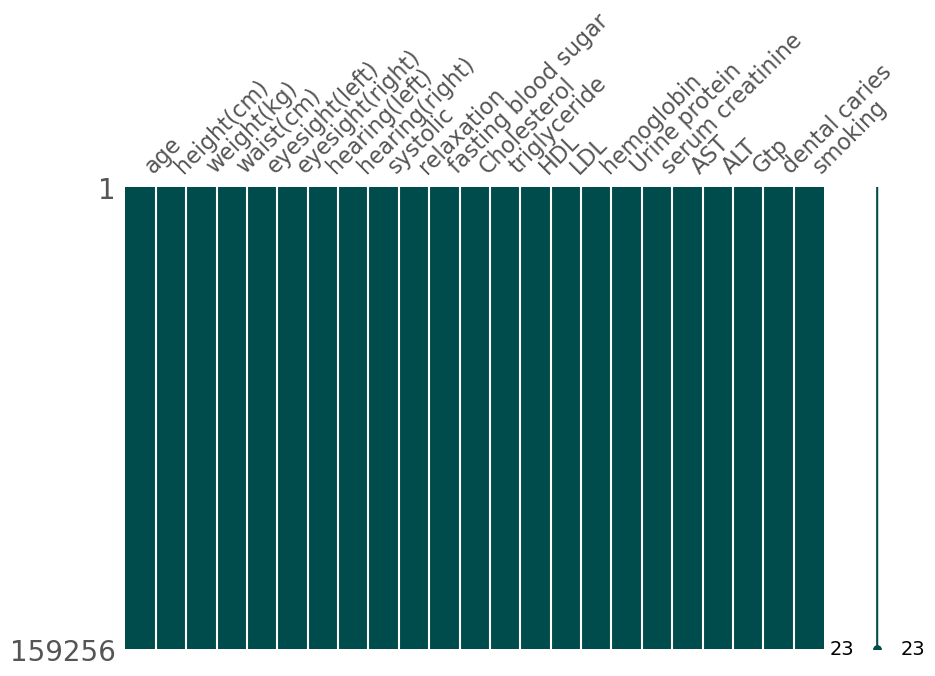

In [39]:
# 欠損値の有無を可視化する
msno.matrix(df=train, figsize=(10, 6), color=(0, .3, .3))

元々欠損値がないデータ

## 尖度（せんど）と歪度（わいど）

- 分布が正規分布からどれだけ歪んでいるかを表す統計量で、左右対称性を示す指標のこと
- 分布が正規分布からどれだけ尖っているかを表す統計量で、山の尖り度と裾の広がり度

In [40]:
print('train: ')
print(train.kurtosis())
print('\n')
print('test: ')
print(test.kurtosis())

train: 
age                      -0.158797
height(cm)               -0.530773
weight(kg)               -0.036576
waist(cm)                -0.056411
eyesight(left)          196.465469
eyesight(right)         192.729347
hearing(left)            36.737645
hearing(right)           37.721184
systolic                  0.212052
relaxation                0.142201
fasting blood sugar      27.200004
Cholesterol              -0.206281
triglyceride              0.996108
HDL                       0.303326
LDL                     323.631298
hemoglobin                0.958526
Urine protein            35.953698
serum creatinine         58.931478
AST                     629.519332
ALT                    4870.241909
Gtp                      69.558428
dental caries             0.297538
smoking                  -1.936252
dtype: float64


test: 
age                      -0.154590
height(cm)               -0.546097
weight(kg)               -0.029519
waist(cm)                -0.016992
eyesight(left)         

### 目的変数の尖度と歪度

In [41]:
# skewness and kurtosis
print("尖度: %f" % target.skew())
print("歪度: %f" % target.kurt())

尖度: 0.252532
歪度: -1.936252


## データセットのプロット（分布）

### 密度関数（ヒストグラム）

In [42]:
numeric_columns = train.select_dtypes(include=['float', 'int']).columns

sns.set(style="whitegrid")

num_plots = len(numeric_columns)
rows = (num_plots + 1) // 2
cols = 2
_, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(8 * cols, 6 * rows))

for i, feature_name in enumerate(numeric_columns):
    row_idx, col_idx = divmod(i, cols)
    sns.histplot(data=train, x=feature_name, kde=True, ax=axes[row_idx, col_idx])
    axes[row_idx, col_idx].set_title(f'Density plot of {feature_name}')
    axes[row_idx, col_idx].set_xlabel('Feature Value')
    axes[row_idx, col_idx].set_ylabel('Density')

plt.tight_layout()

plt.show()

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'height(cm)'}>,
        <Axes: title={'center': 'weight(kg)'}>,
        <Axes: title={'center': 'waist(cm)'}>,
        <Axes: title={'center': 'eyesight(left)'}>],
       [<Axes: title={'center': 'eyesight(right)'}>,
        <Axes: title={'center': 'hearing(left)'}>,
        <Axes: title={'center': 'hearing(right)'}>,
        <Axes: title={'center': 'systolic'}>,
        <Axes: title={'center': 'relaxation'}>],
       [<Axes: title={'center': 'fasting blood sugar'}>,
        <Axes: title={'center': 'Cholesterol'}>,
        <Axes: title={'center': 'triglyceride'}>,
        <Axes: title={'center': 'HDL'}>, <Axes: title={'center': 'LDL'}>],
       [<Axes: title={'center': 'hemoglobin'}>,
        <Axes: title={'center': 'Urine protein'}>,
        <Axes: title={'center': 'serum creatinine'}>,
        <Axes: title={'center': 'AST'}>, <Axes: title={'center': 'ALT'}>],
       [<Axes: title={'center': 'Gtp'}>,
        <Axe

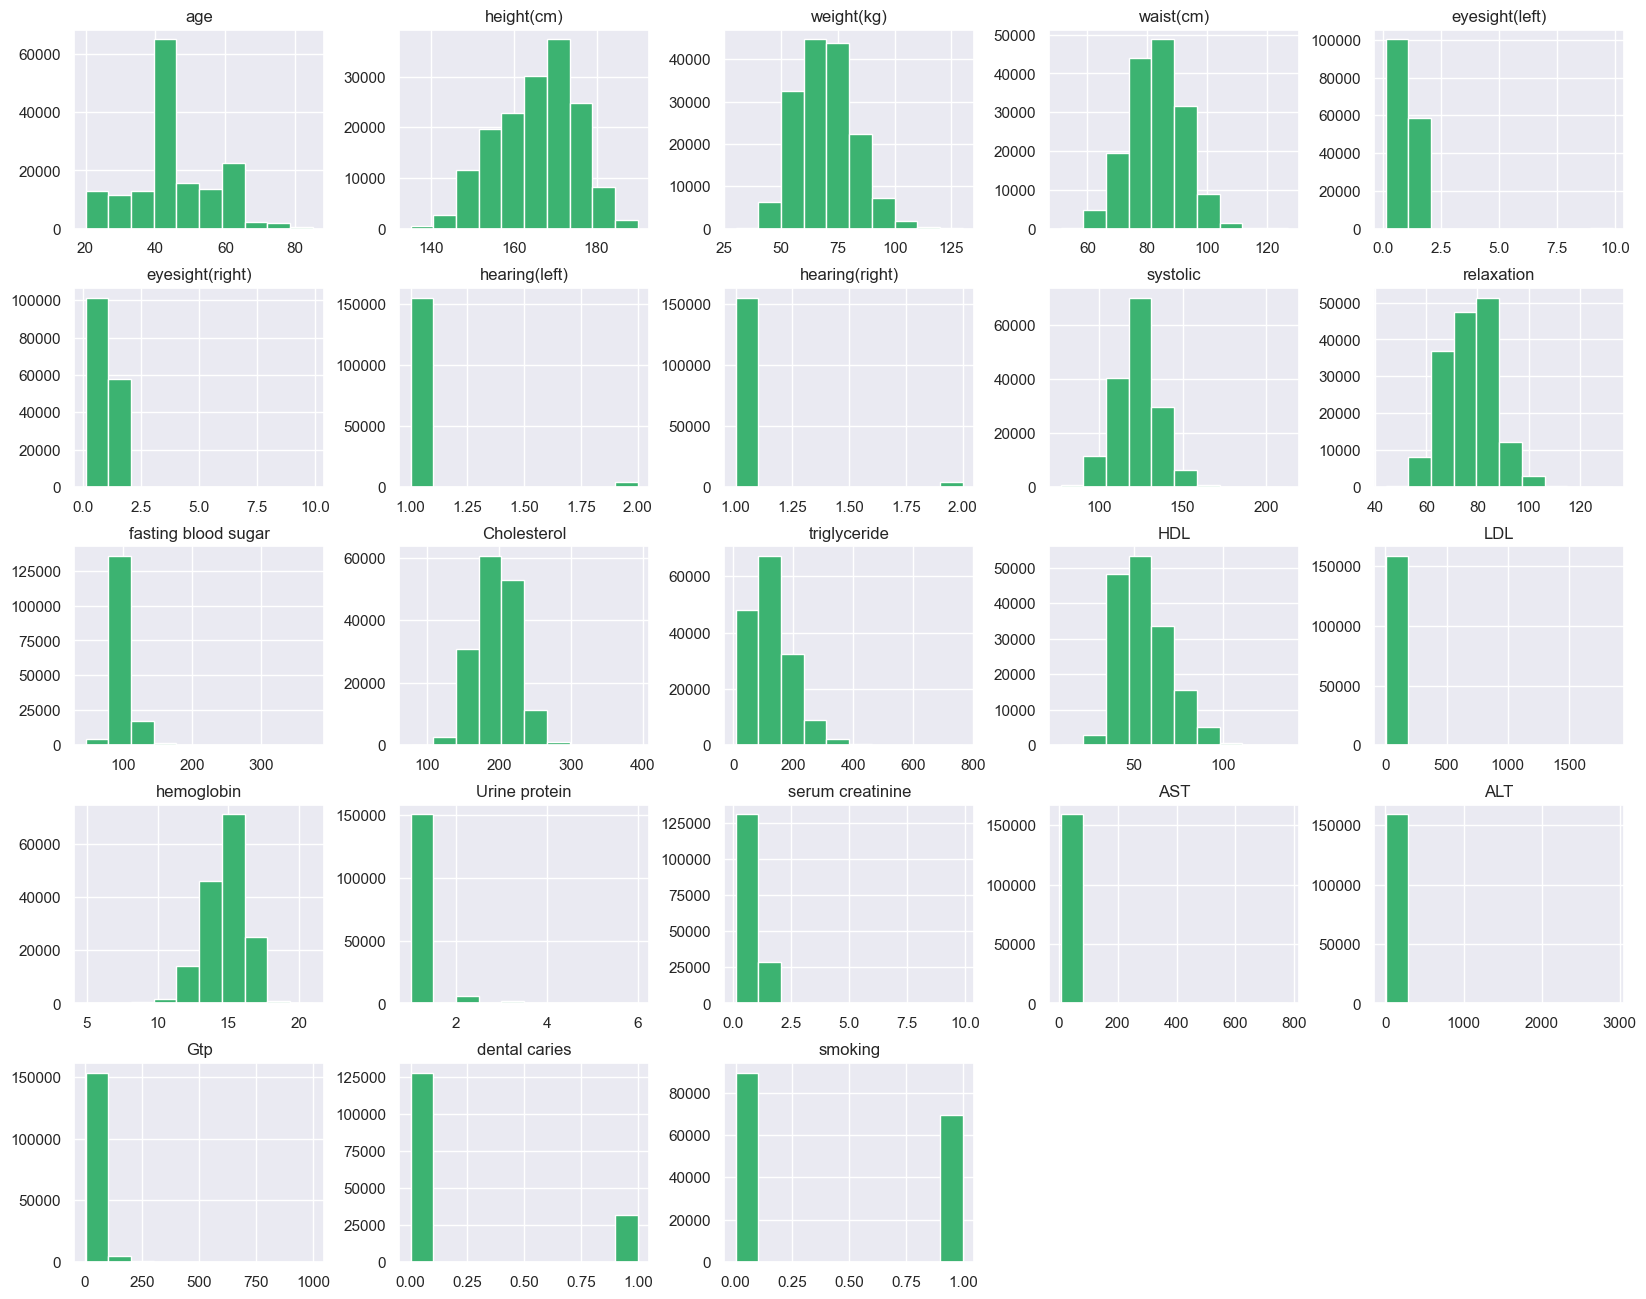

In [ ]:
sns.set(rc={'figure.figsize': (20, 16)})
train.hist(color='mediumseagreen')

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'height(cm)'}>,
        <Axes: title={'center': 'weight(kg)'}>,
        <Axes: title={'center': 'waist(cm)'}>,
        <Axes: title={'center': 'eyesight(left)'}>],
       [<Axes: title={'center': 'eyesight(right)'}>,
        <Axes: title={'center': 'hearing(left)'}>,
        <Axes: title={'center': 'hearing(right)'}>,
        <Axes: title={'center': 'systolic'}>,
        <Axes: title={'center': 'relaxation'}>],
       [<Axes: title={'center': 'fasting blood sugar'}>,
        <Axes: title={'center': 'Cholesterol'}>,
        <Axes: title={'center': 'triglyceride'}>,
        <Axes: title={'center': 'HDL'}>, <Axes: title={'center': 'LDL'}>],
       [<Axes: title={'center': 'hemoglobin'}>,
        <Axes: title={'center': 'Urine protein'}>,
        <Axes: title={'center': 'serum creatinine'}>,
        <Axes: title={'center': 'AST'}>, <Axes: title={'center': 'ALT'}>],
       [<Axes: title={'center': 'Gtp'}>,
        <Axe

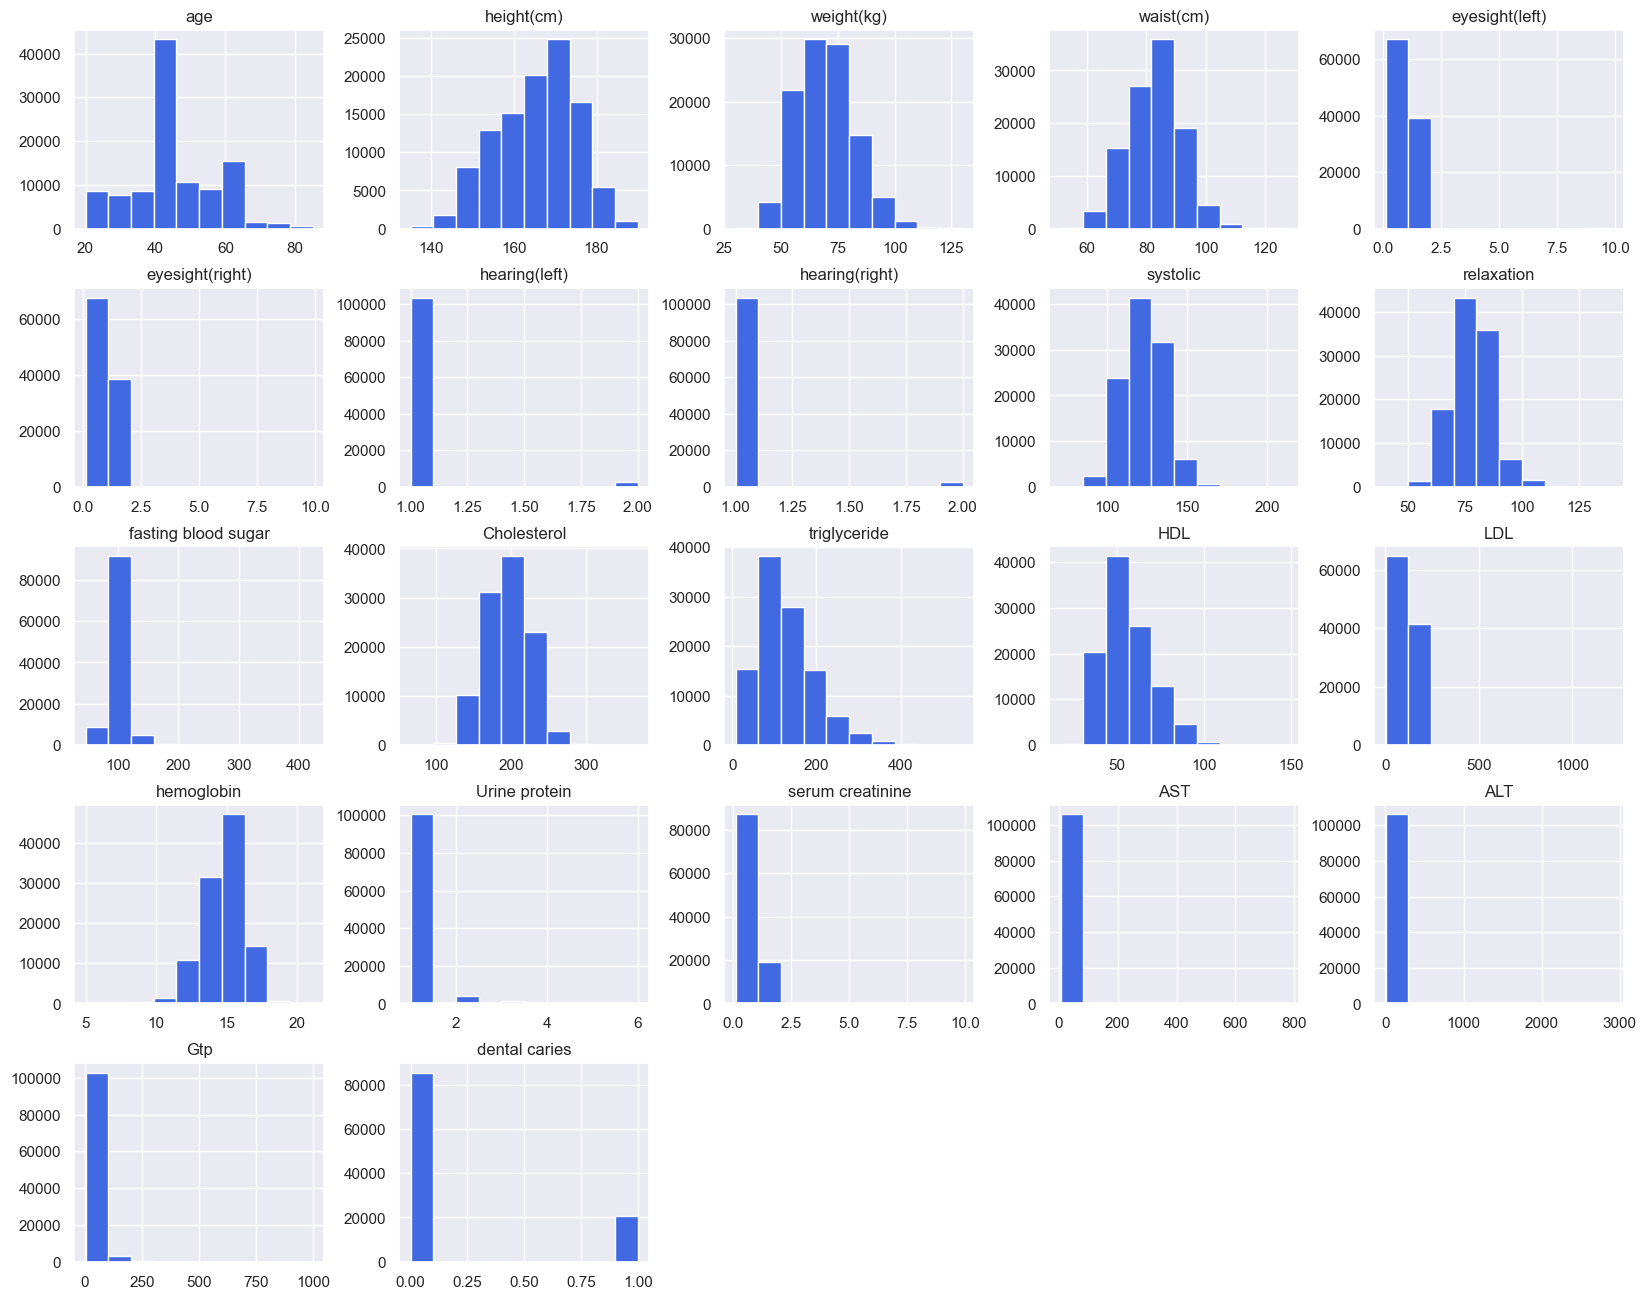

In [ ]:
sns.set(rc={'figure.figsize': (20, 16)})
test.hist(color='royalblue')

#### データの分布を可視化する

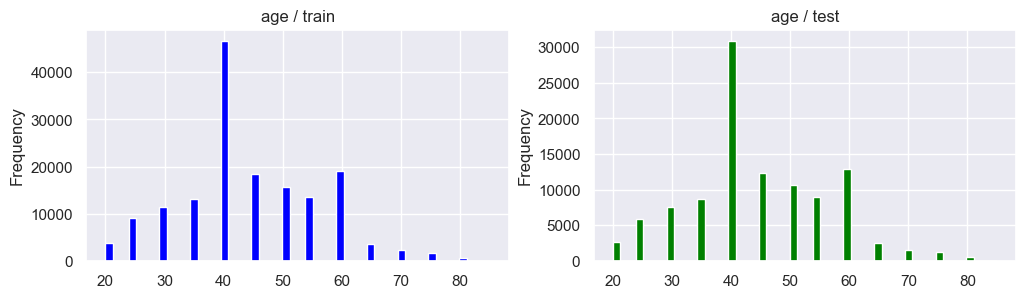

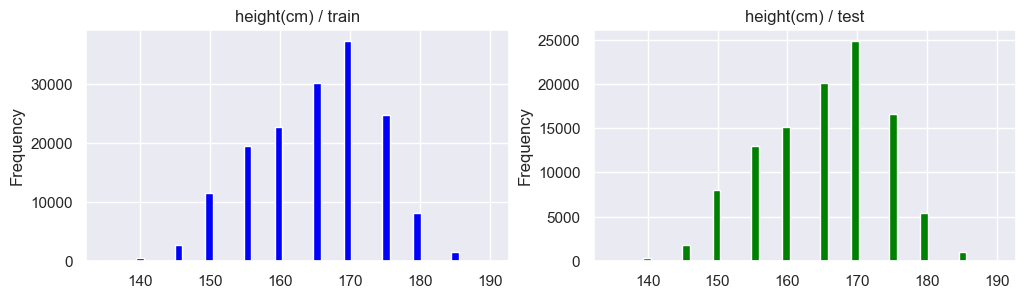

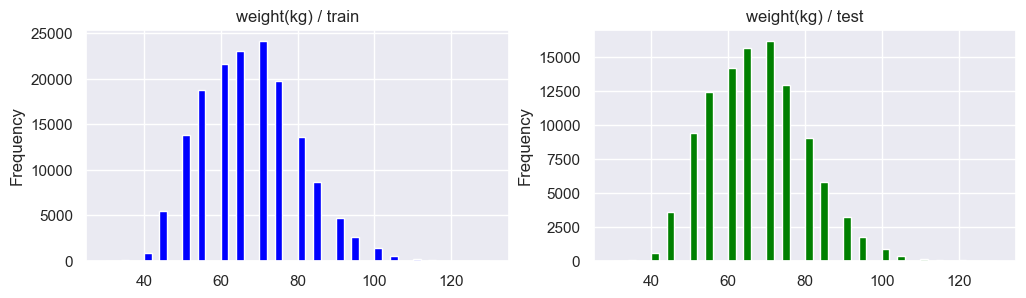

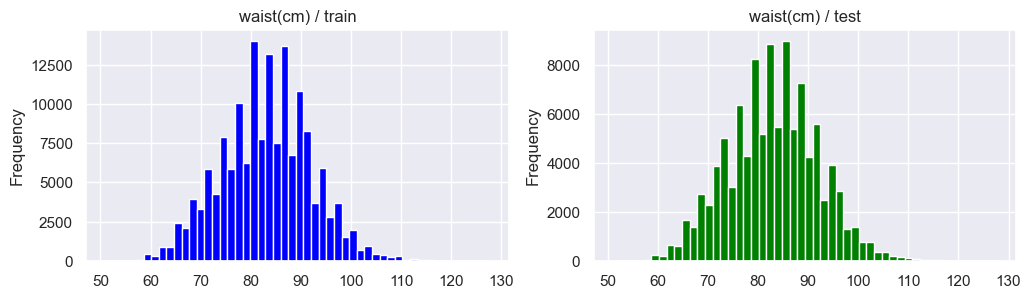

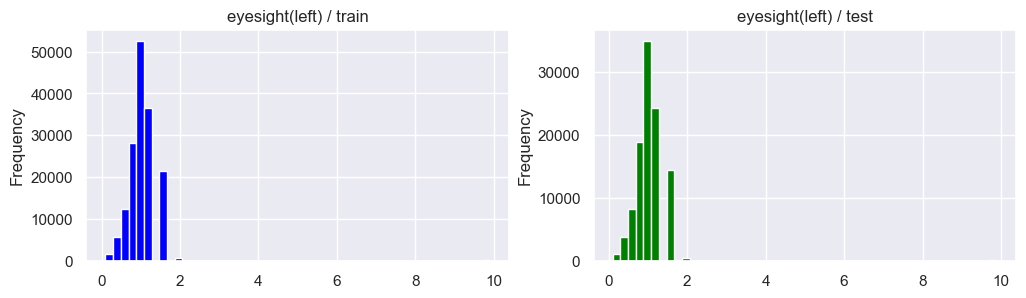

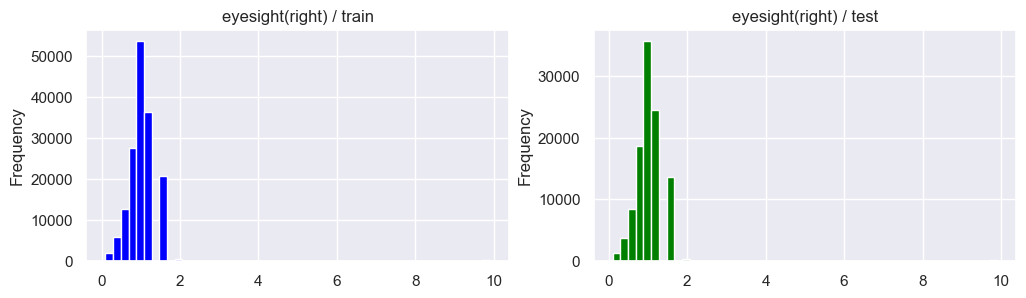

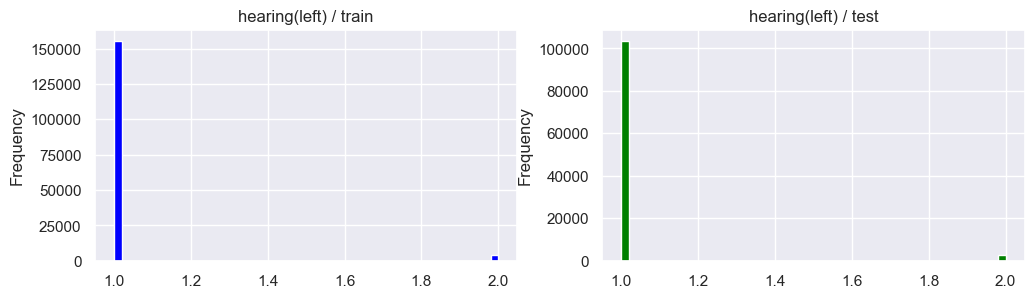

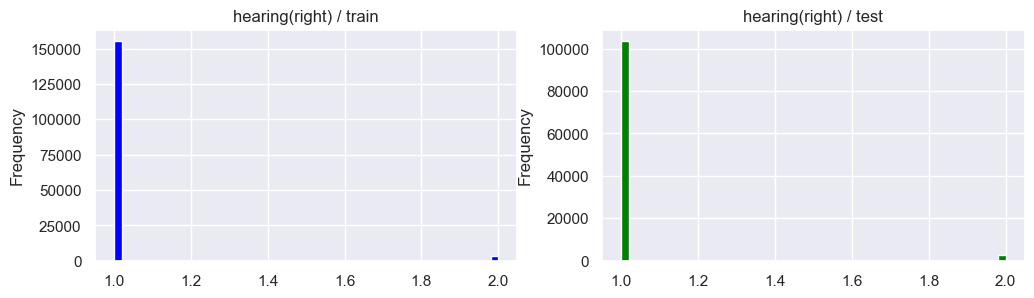

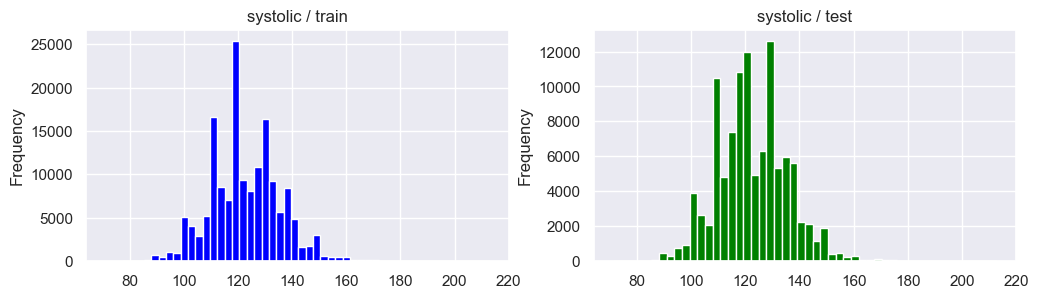

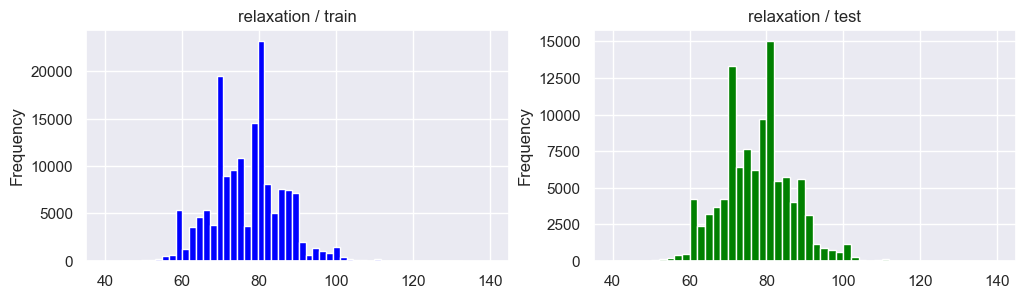

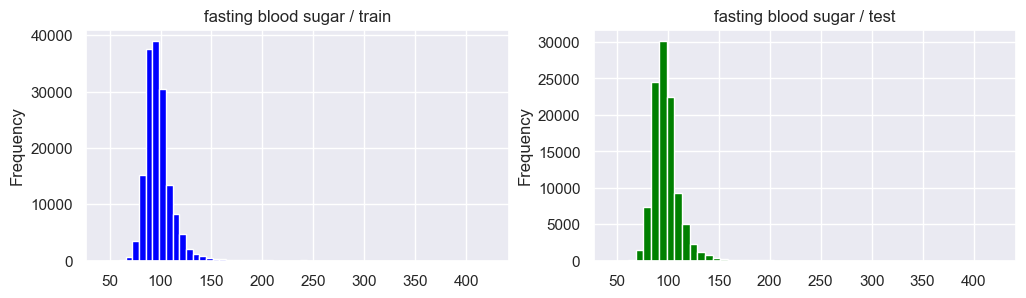

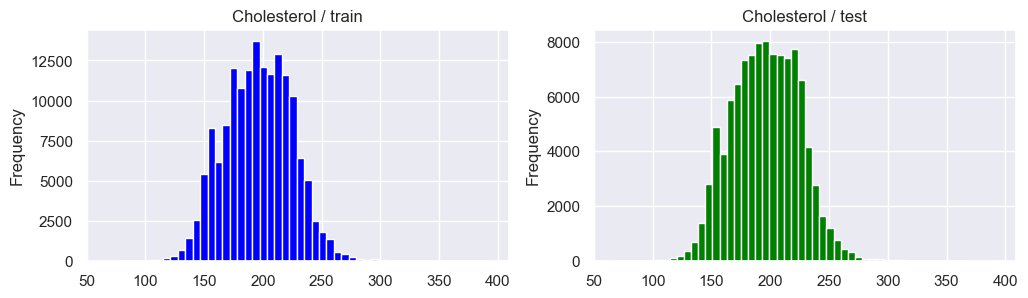

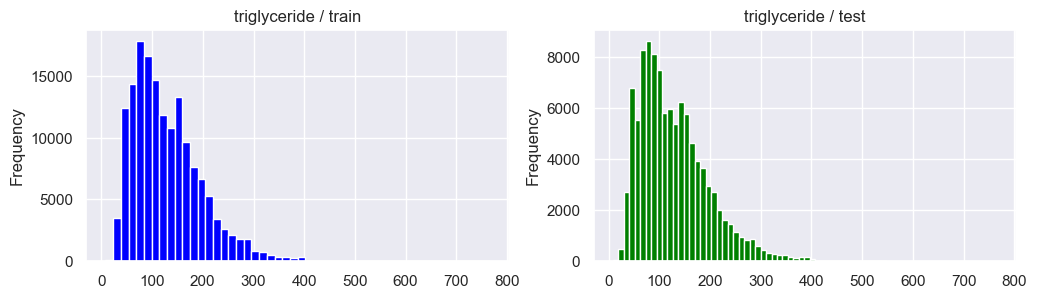

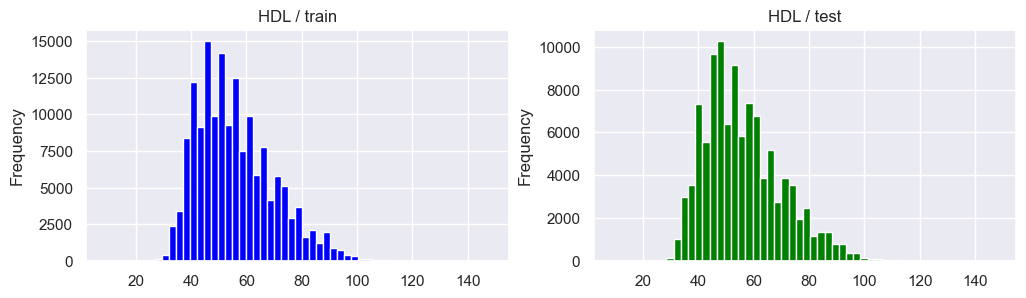

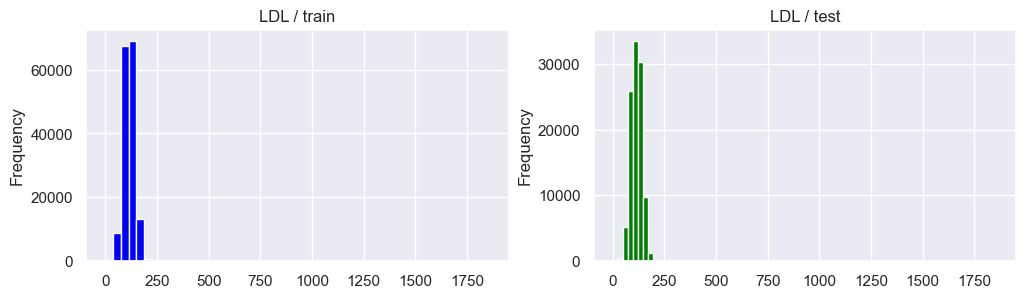

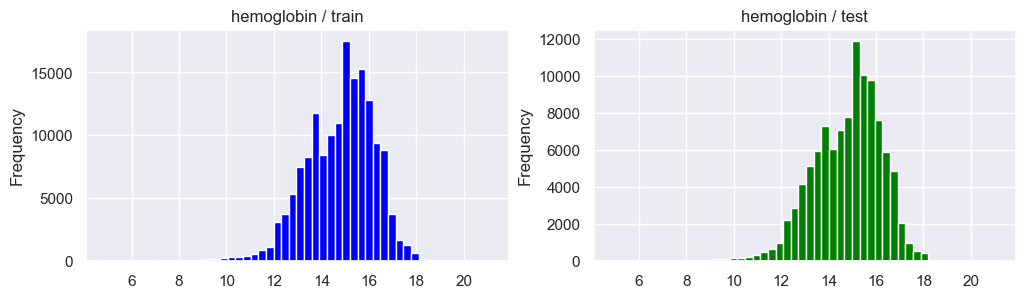

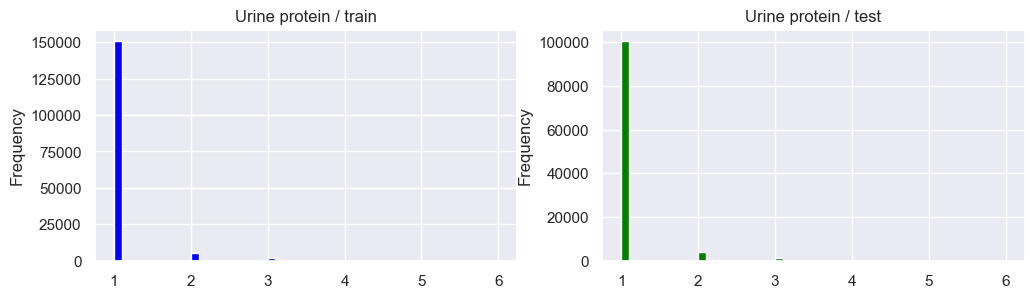

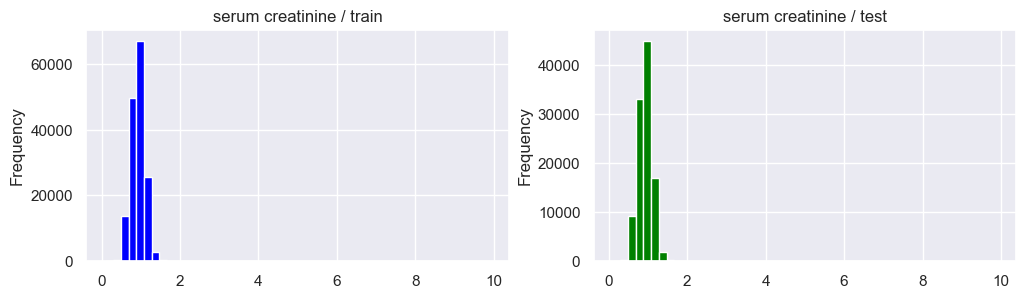

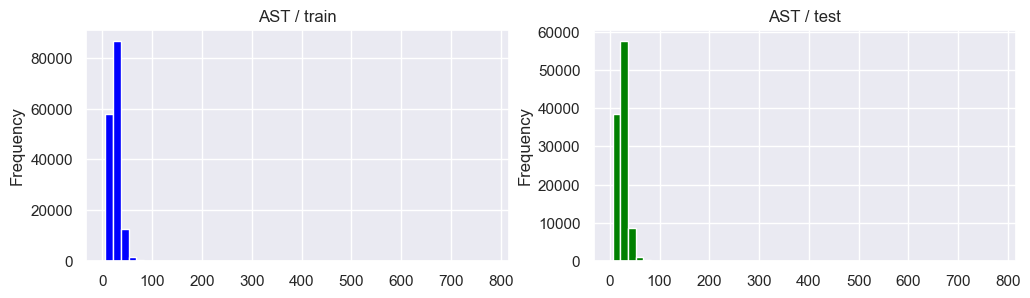

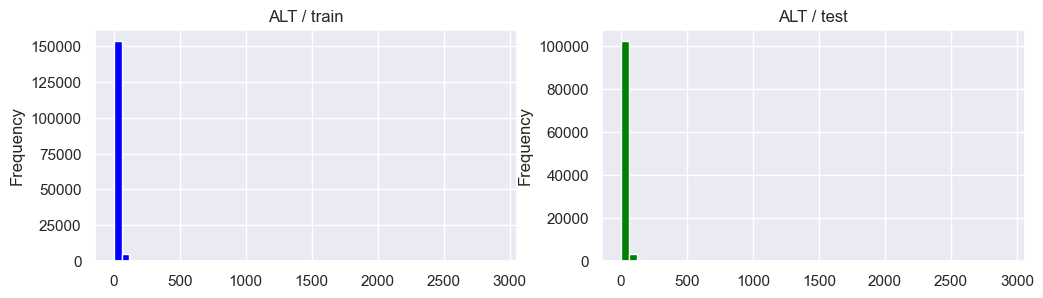

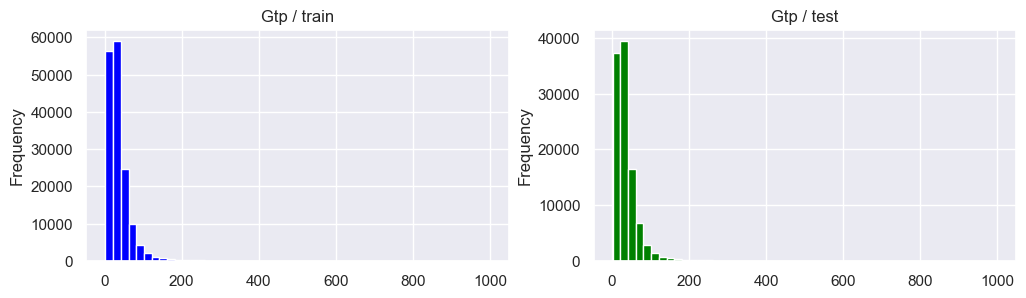

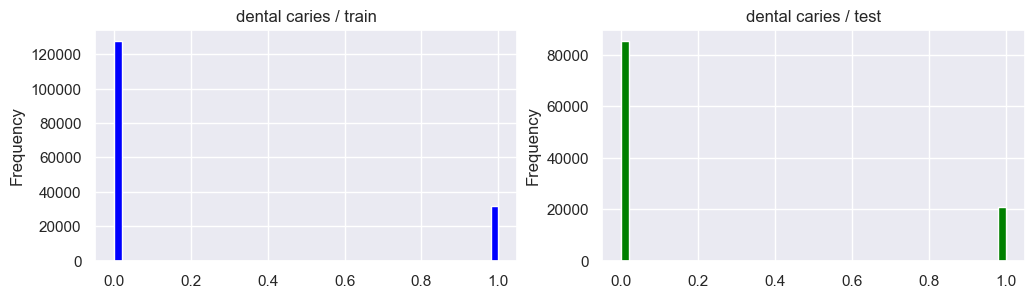

In [ ]:
feature = train.columns.drop(['smoking']).tolist() # 目的変数を指定する

for feat in feature:
    plt.figure(figsize=(12, 3))
    ax1 = plt.subplot(1, 2, 1)
    train[feat].plot(kind='hist', bins=50, color='blue')
    plt.title(feat + ' / train')
    ax2 = plt.subplot(1, 2, 2, sharex=ax1)
    test[feat].plot(kind='hist', bins=50, color='green')
    plt.title(feat + ' / test')
    
    plt.show()

#### データを対数変換する

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'height(cm)'}>,
        <Axes: title={'center': 'weight(kg)'}>,
        <Axes: title={'center': 'waist(cm)'}>,
        <Axes: title={'center': 'eyesight(left)'}>],
       [<Axes: title={'center': 'eyesight(right)'}>,
        <Axes: title={'center': 'hearing(left)'}>,
        <Axes: title={'center': 'hearing(right)'}>,
        <Axes: title={'center': 'systolic'}>,
        <Axes: title={'center': 'relaxation'}>],
       [<Axes: title={'center': 'fasting blood sugar'}>,
        <Axes: title={'center': 'Cholesterol'}>,
        <Axes: title={'center': 'triglyceride'}>,
        <Axes: title={'center': 'HDL'}>, <Axes: title={'center': 'LDL'}>],
       [<Axes: title={'center': 'hemoglobin'}>,
        <Axes: title={'center': 'Urine protein'}>,
        <Axes: title={'center': 'serum creatinine'}>,
        <Axes: title={'center': 'AST'}>, <Axes: title={'center': 'ALT'}>],
       [<Axes: title={'center': 'Gtp'}>,
        <Axe

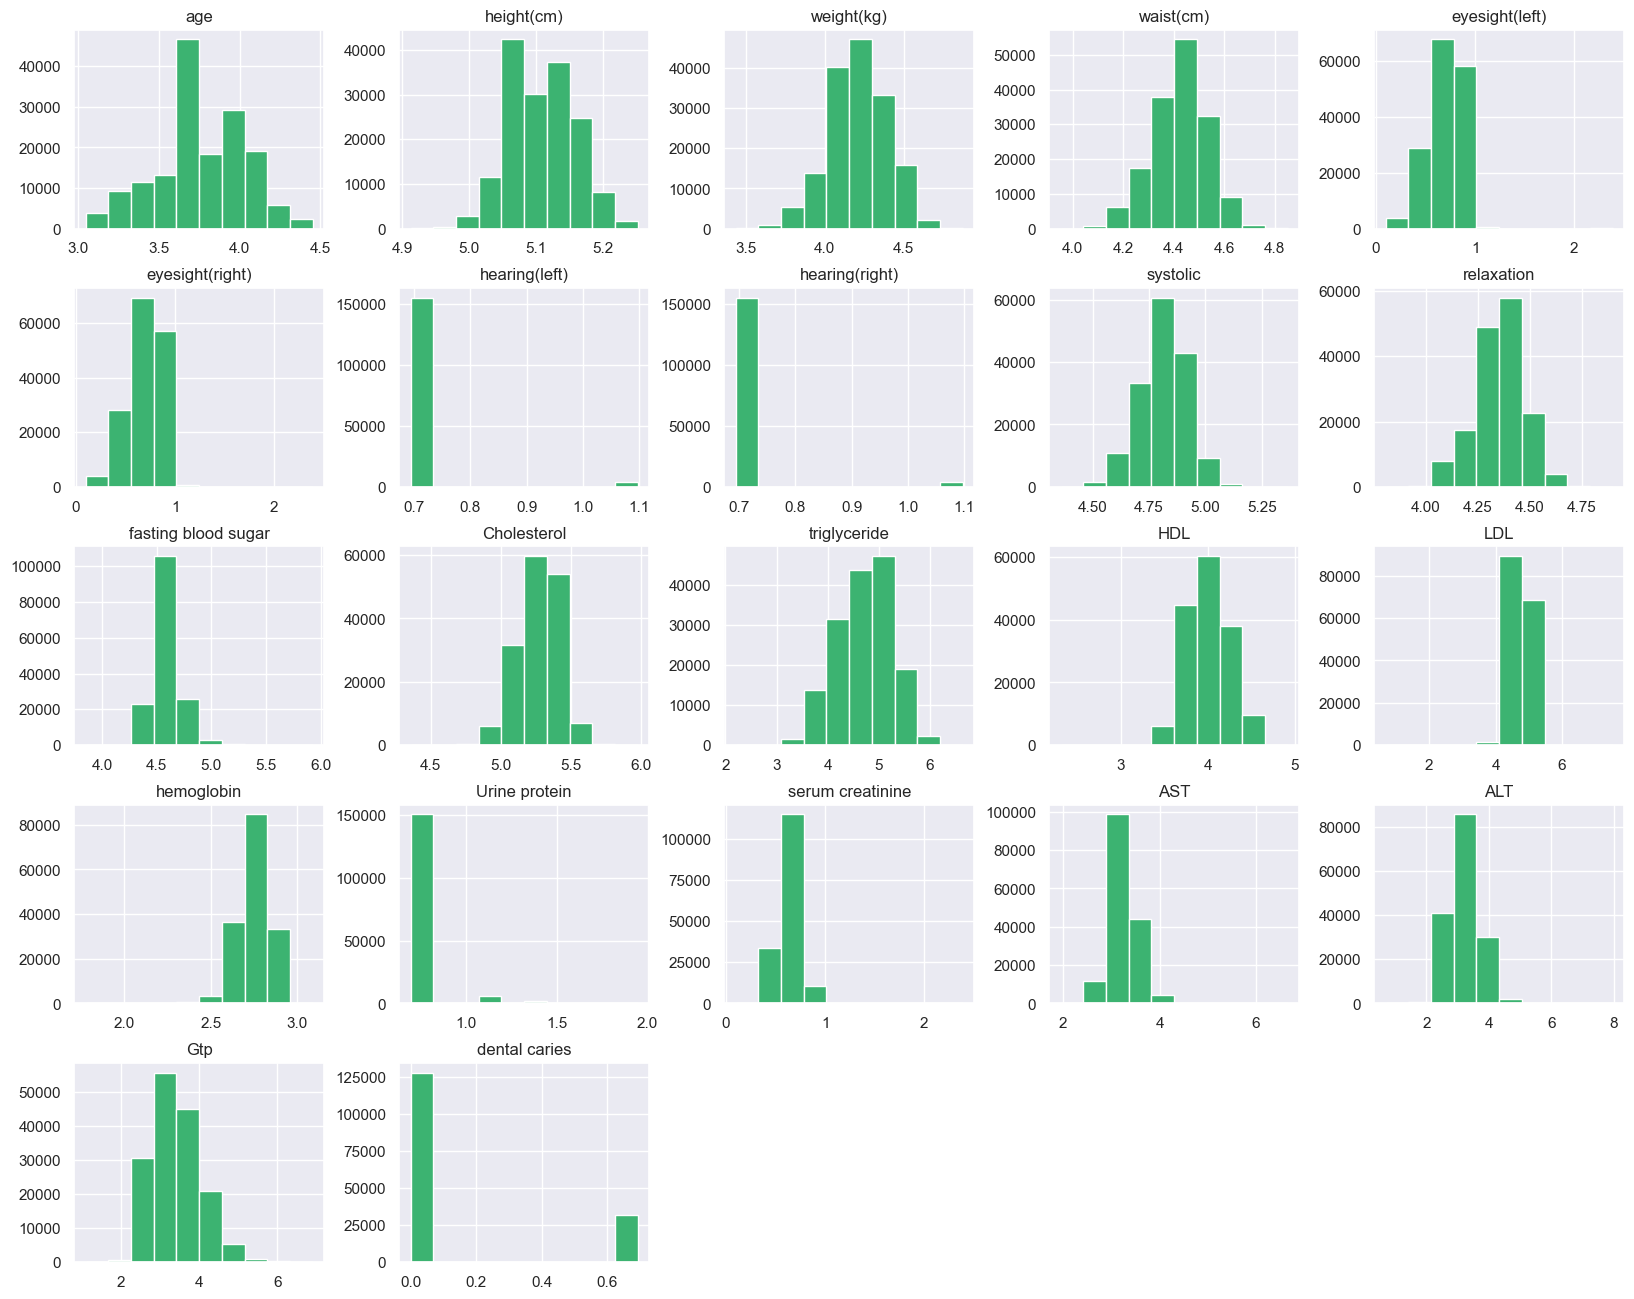

In [ ]:
# 訓練データをX(説明変数)とy（目的変数）に分割する
X = train.drop(['smoking'], axis=1)
y = train.smoking # == target

for column in X.columns.tolist():
    X[column] = X[column].apply(lambda x: np.log(x + 1))

X.hist(color='mediumseagreen')

array([[<Axes: title={'center': 'age'}>,
        <Axes: title={'center': 'height(cm)'}>,
        <Axes: title={'center': 'weight(kg)'}>,
        <Axes: title={'center': 'waist(cm)'}>,
        <Axes: title={'center': 'eyesight(left)'}>],
       [<Axes: title={'center': 'eyesight(right)'}>,
        <Axes: title={'center': 'hearing(left)'}>,
        <Axes: title={'center': 'hearing(right)'}>,
        <Axes: title={'center': 'systolic'}>,
        <Axes: title={'center': 'relaxation'}>],
       [<Axes: title={'center': 'fasting blood sugar'}>,
        <Axes: title={'center': 'Cholesterol'}>,
        <Axes: title={'center': 'triglyceride'}>,
        <Axes: title={'center': 'HDL'}>, <Axes: title={'center': 'LDL'}>],
       [<Axes: title={'center': 'hemoglobin'}>,
        <Axes: title={'center': 'Urine protein'}>,
        <Axes: title={'center': 'serum creatinine'}>,
        <Axes: title={'center': 'AST'}>, <Axes: title={'center': 'ALT'}>],
       [<Axes: title={'center': 'Gtp'}>,
        <Axe

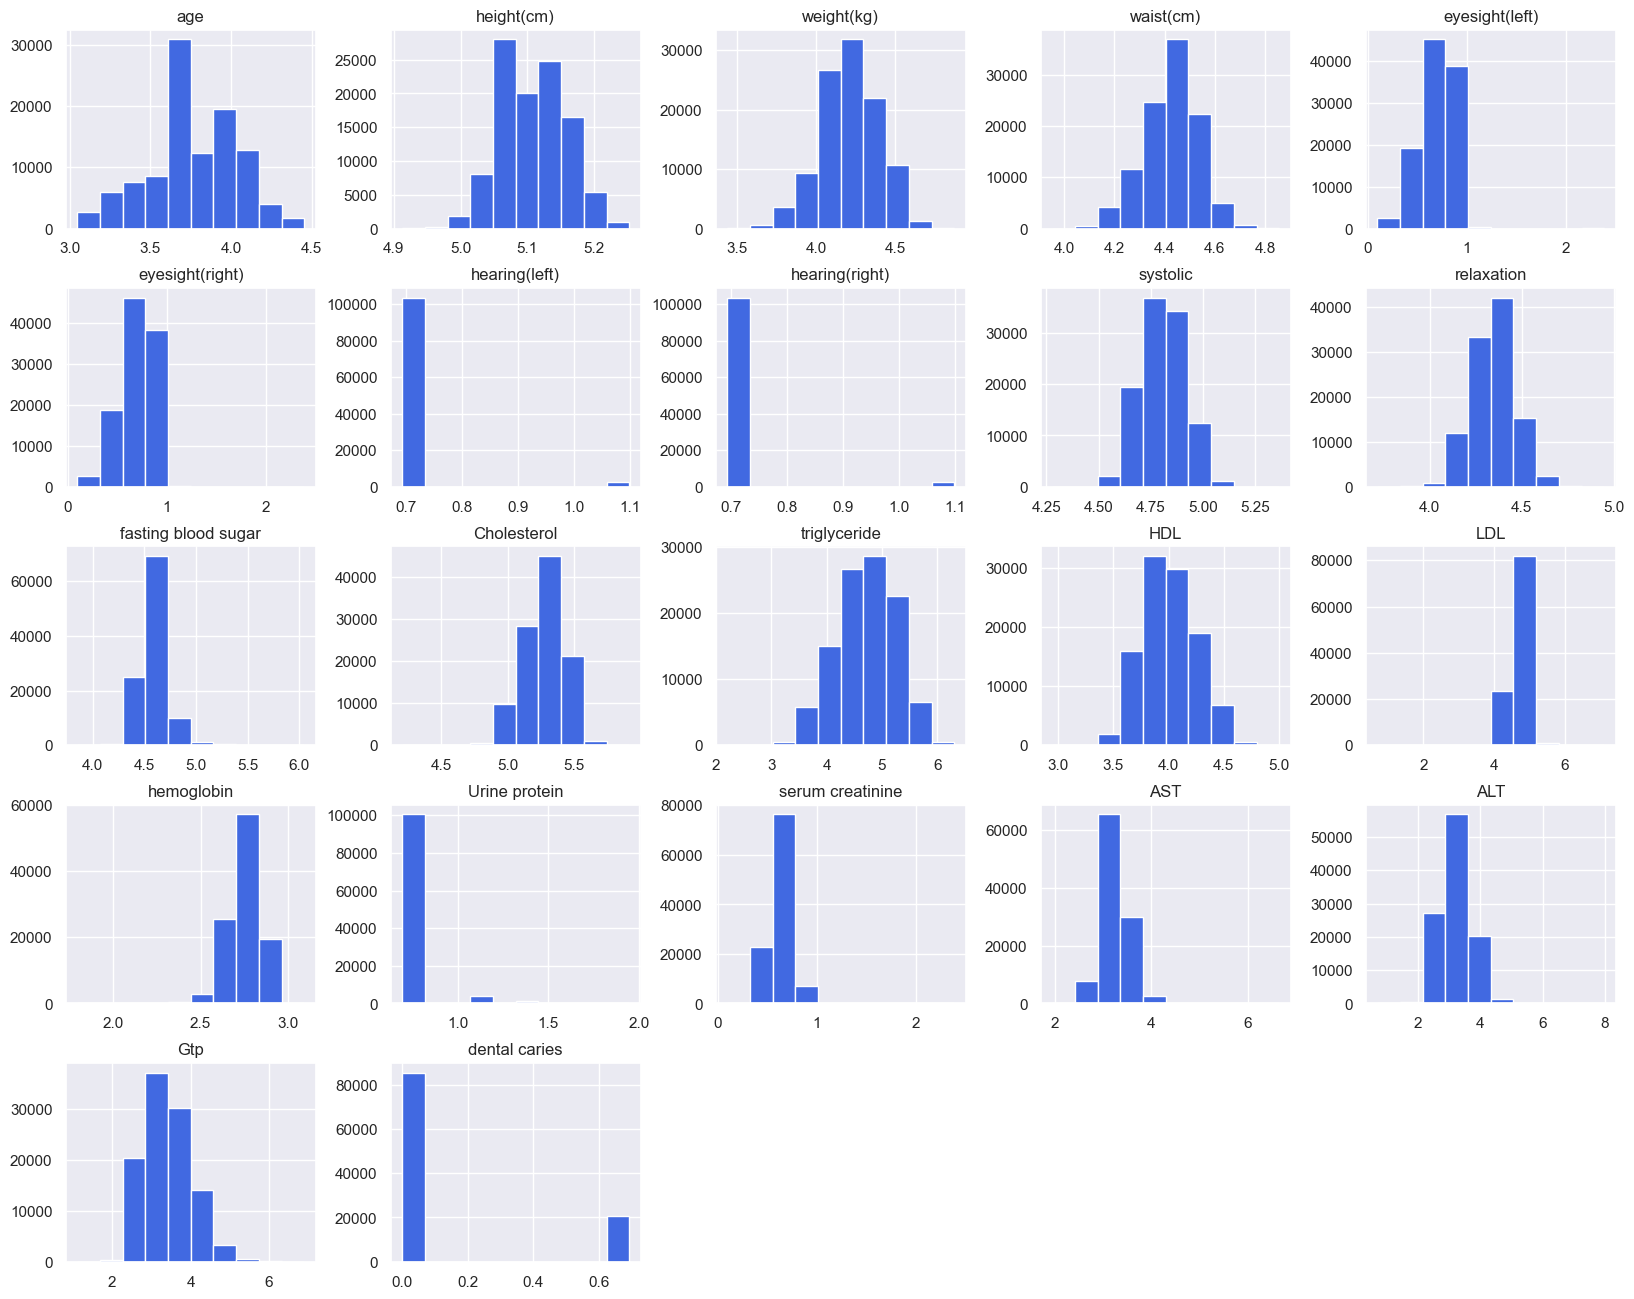

In [ ]:
# テストデータも変換する
test_log = test
for column in test_log.columns.tolist():
    test_log[column] = test_log[column].apply(lambda x: np.log(x + 1))

test_log.hist(color='royalblue')

### 円グラフ：　目的変数（smoking）

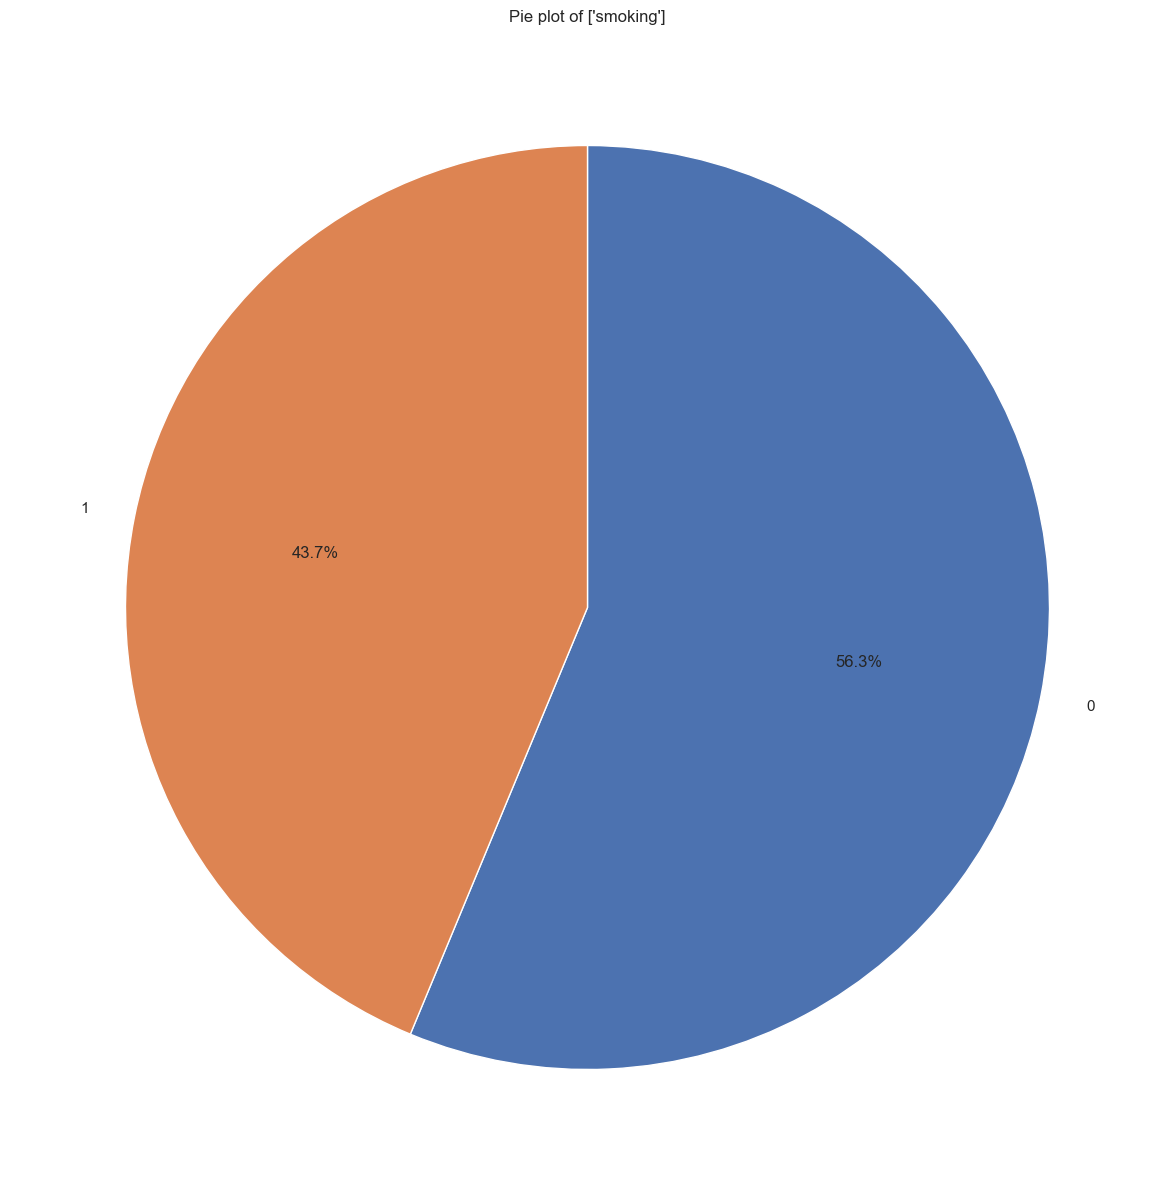

In [ ]:
label_counts = target.value_counts()
# plt.style.use('fivethirtyeight')
plt.figure(figsize=(15, 15))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=90,
        counterclock=False)
plt.title('Pie plot of ' + target_name)
plt.show()

### 箱ひげ図

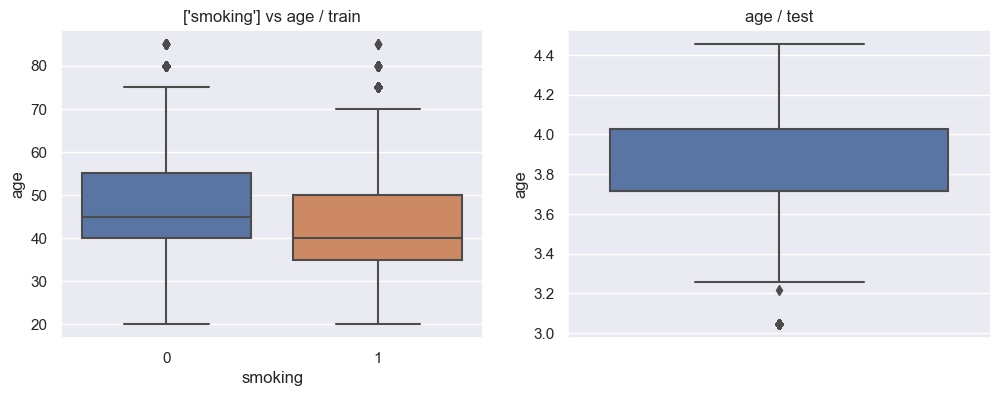

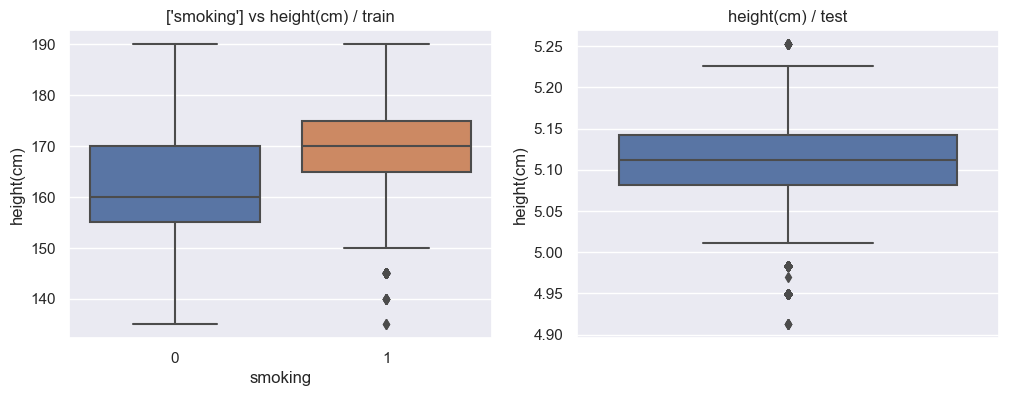

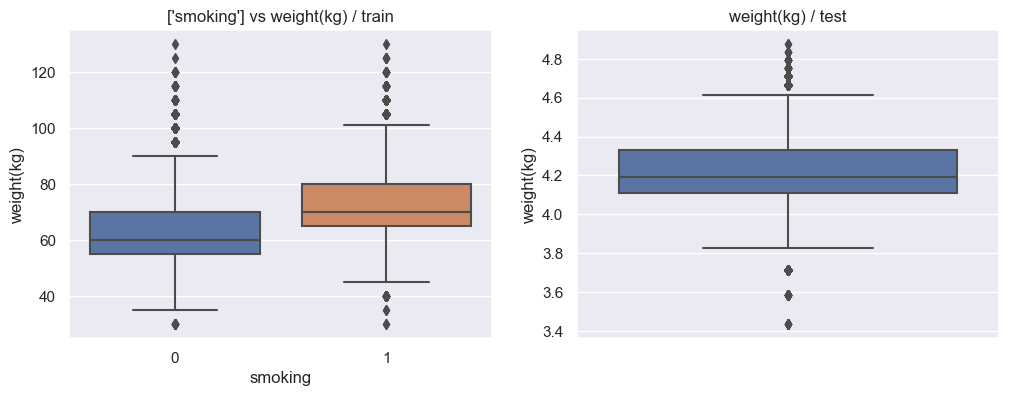

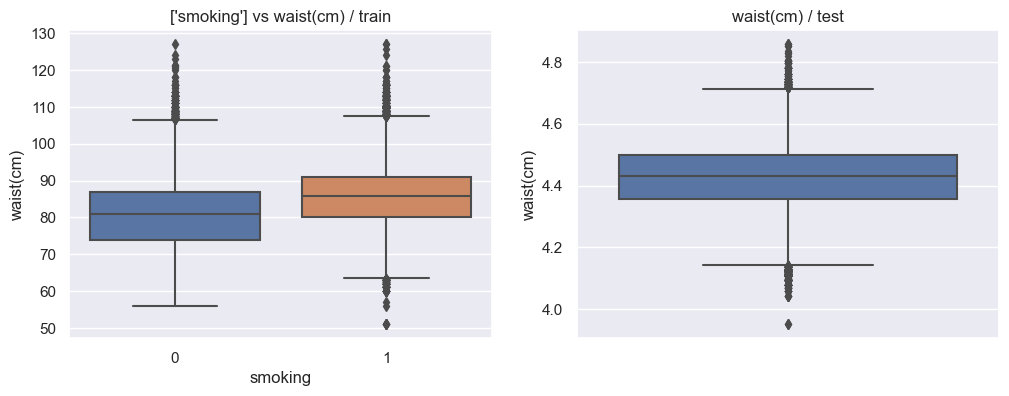

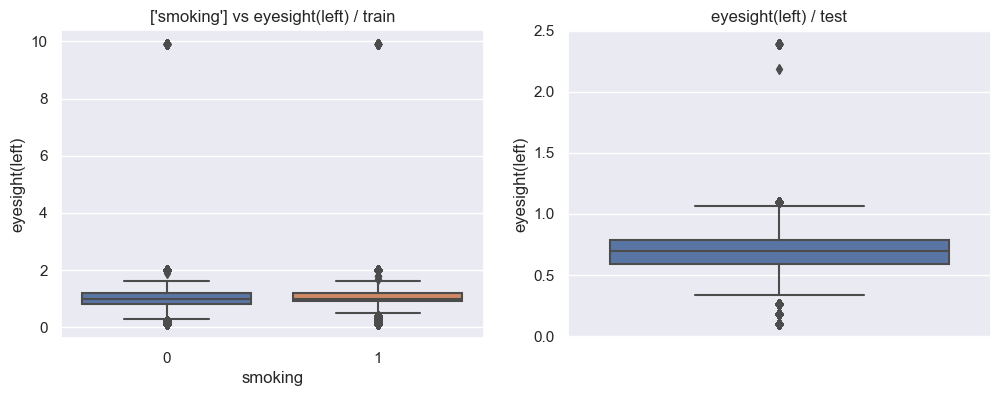

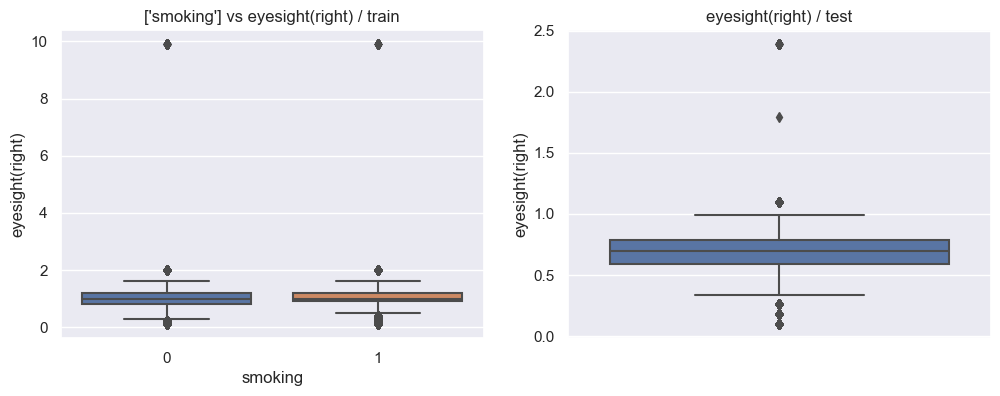

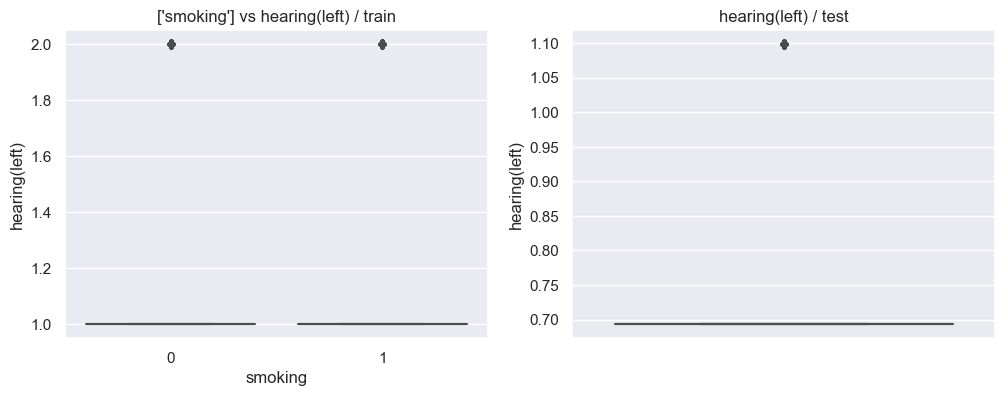

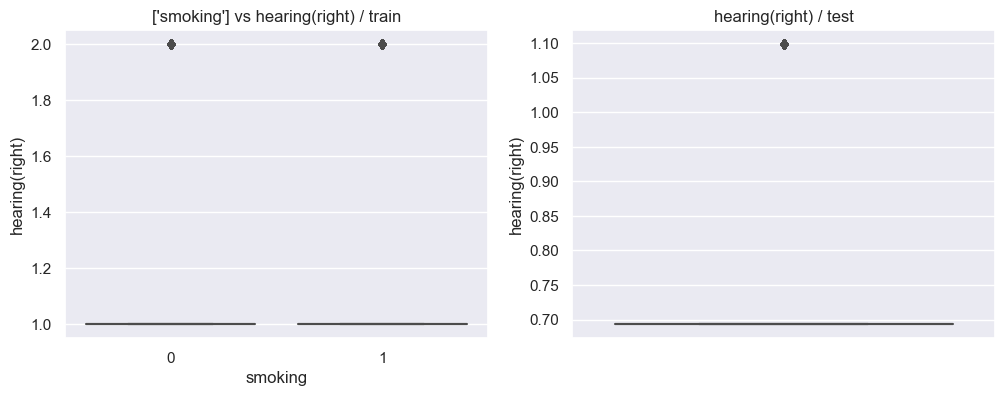

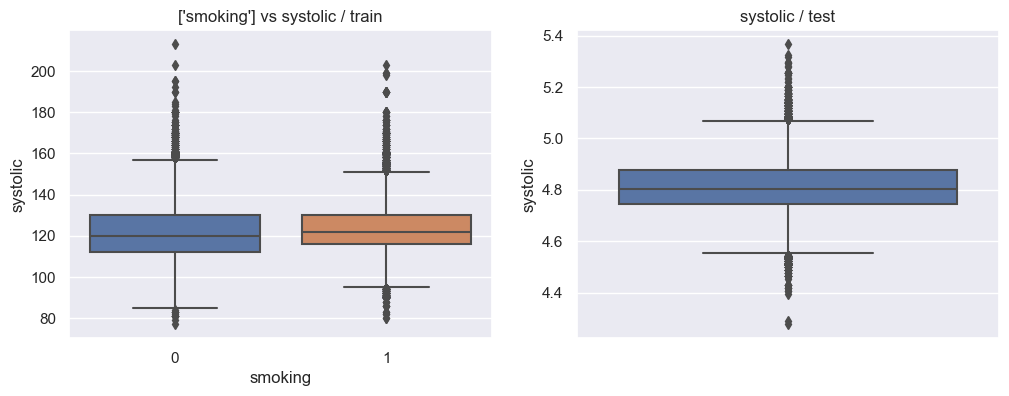

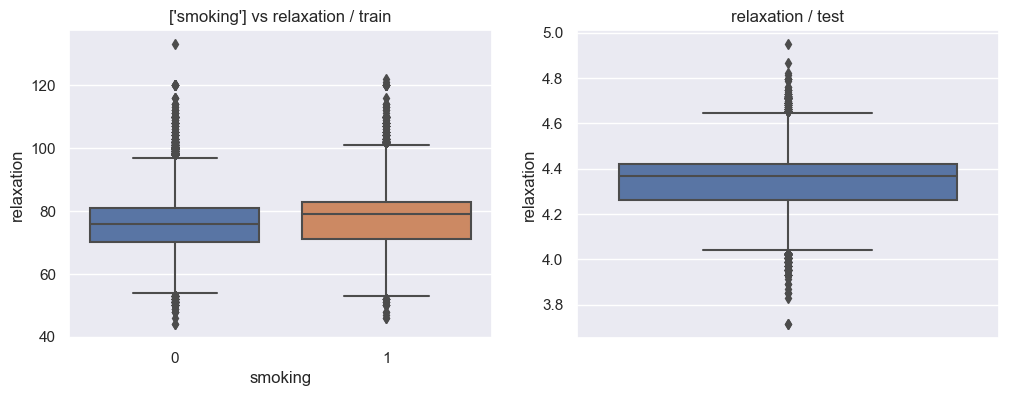

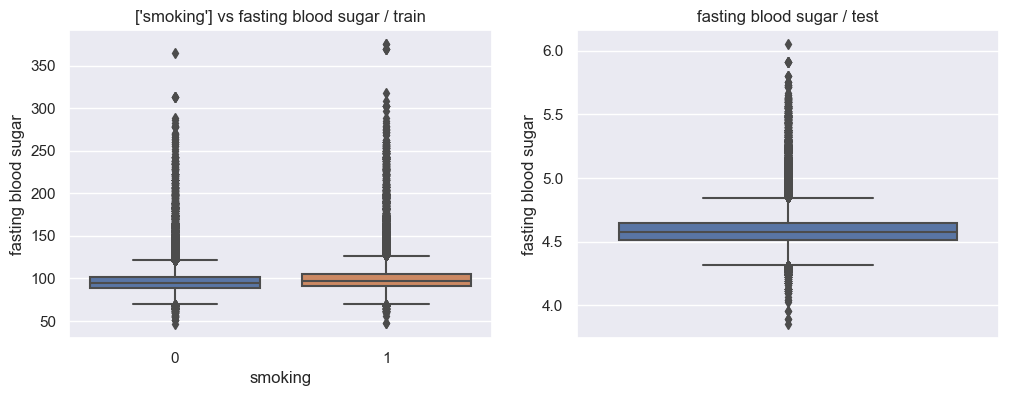

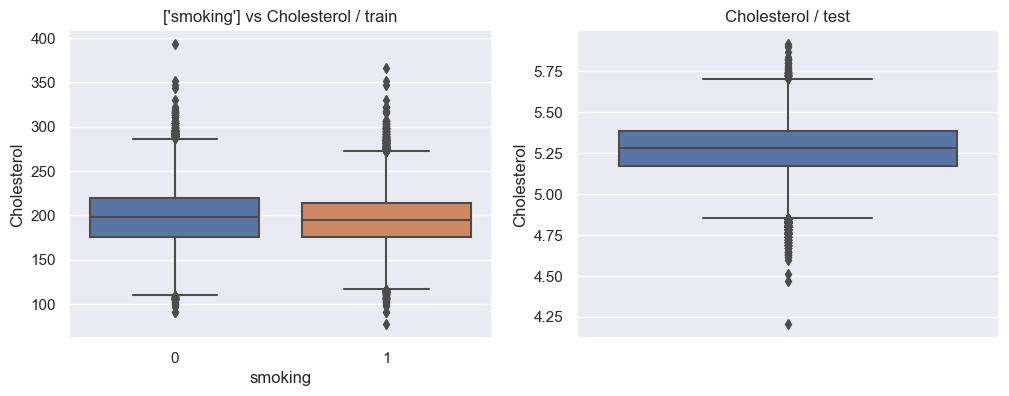

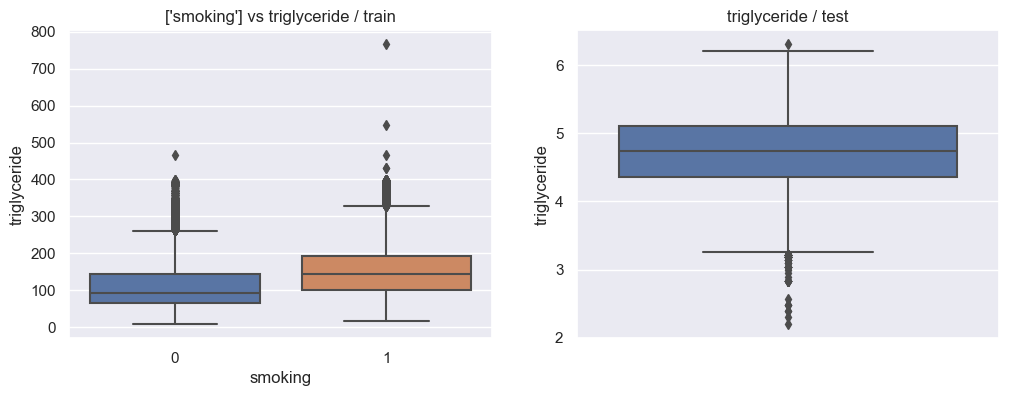

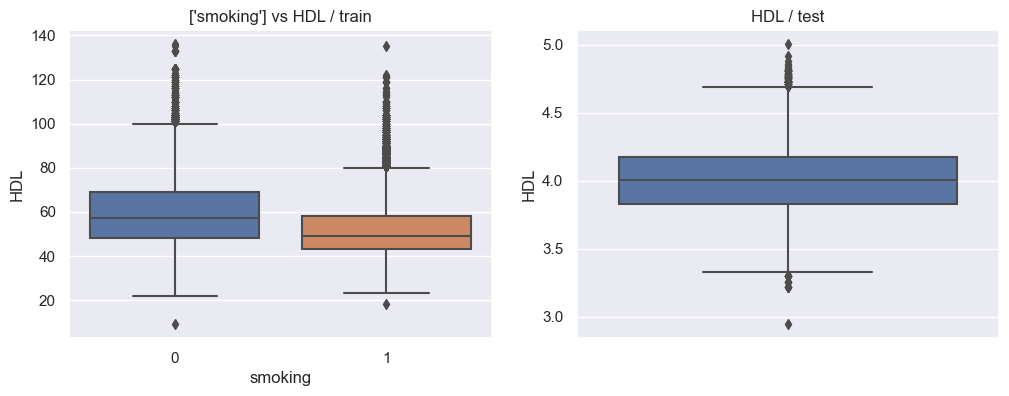

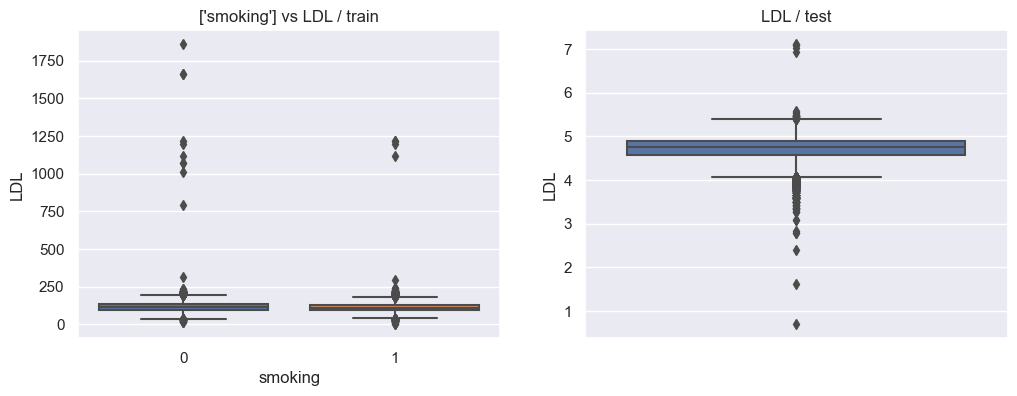

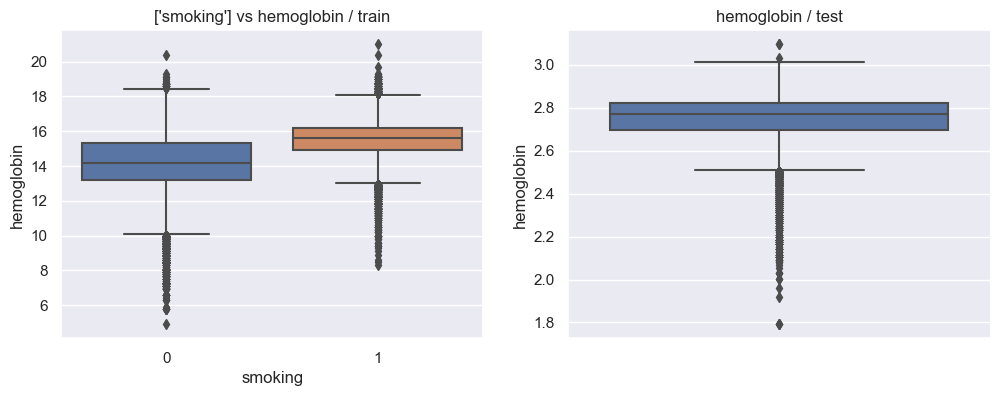

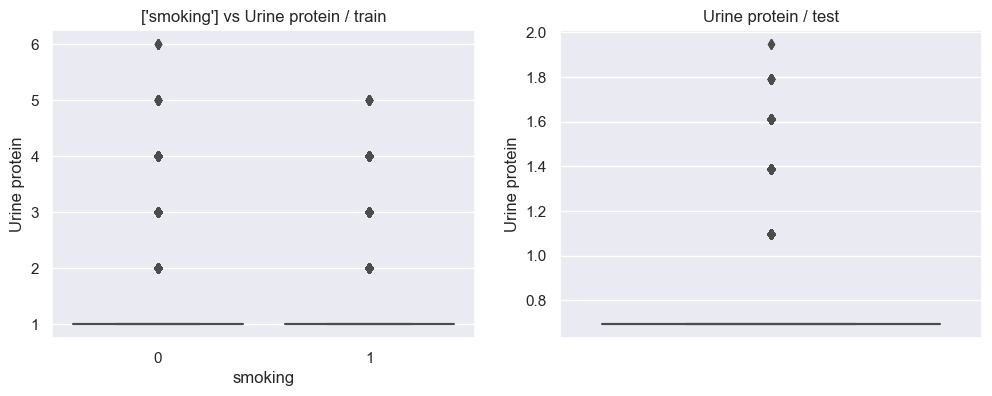

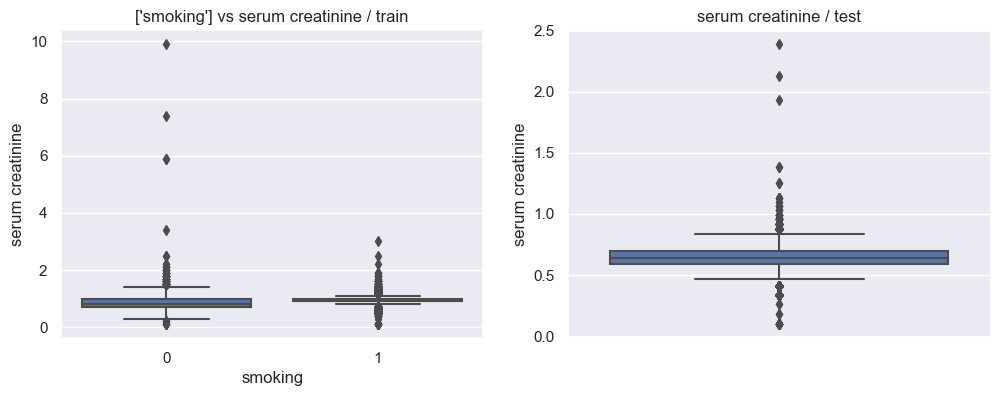

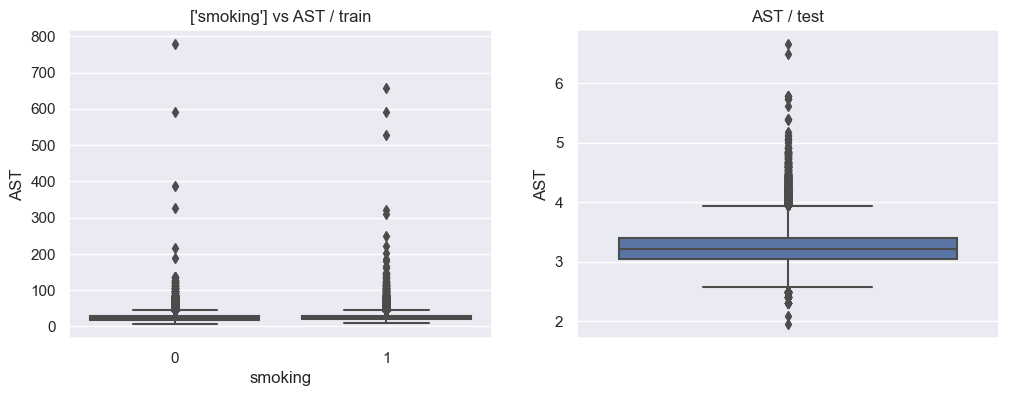

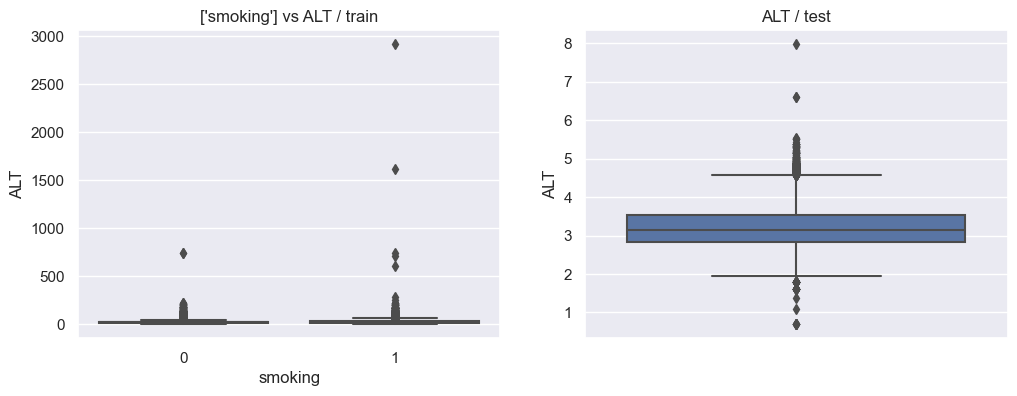

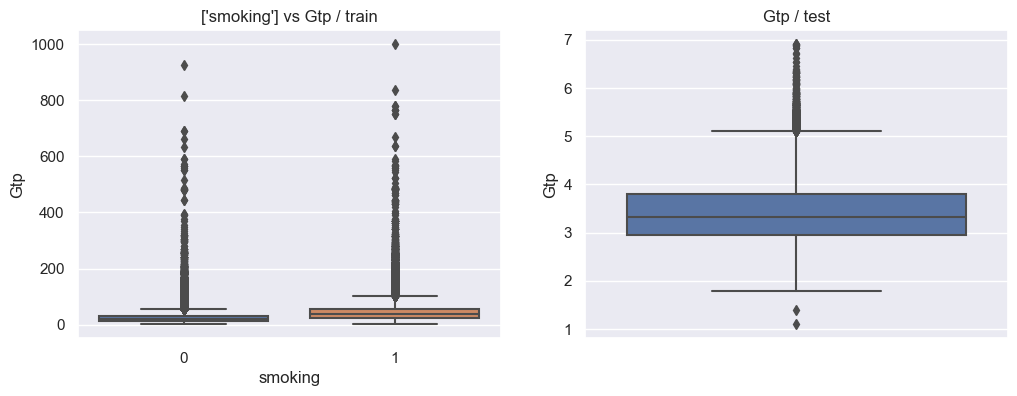

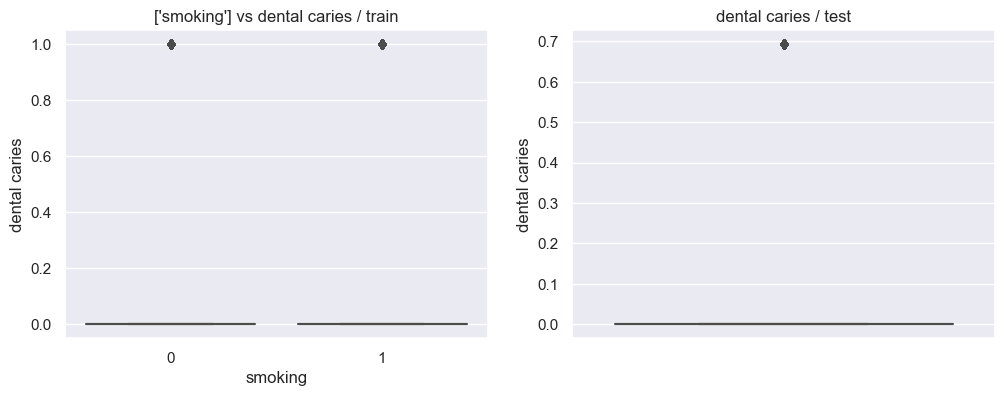

In [ ]:
for feat in feature:
    plt.figure(figsize=(12, 4))
    ax1 = plt.subplot(1, 2, 1)
    sns.boxplot(data=train, x=target, y=feat)
    plt.title(target_name + ' vs ' + feat + ' / train')
    x1 = plt.subplot(1, 2, 2)
    sns.boxplot(data=test, y=feat)
    plt.title(feat + ' / test')
    plt.show()

#### 箱ひげ図（目的変数）

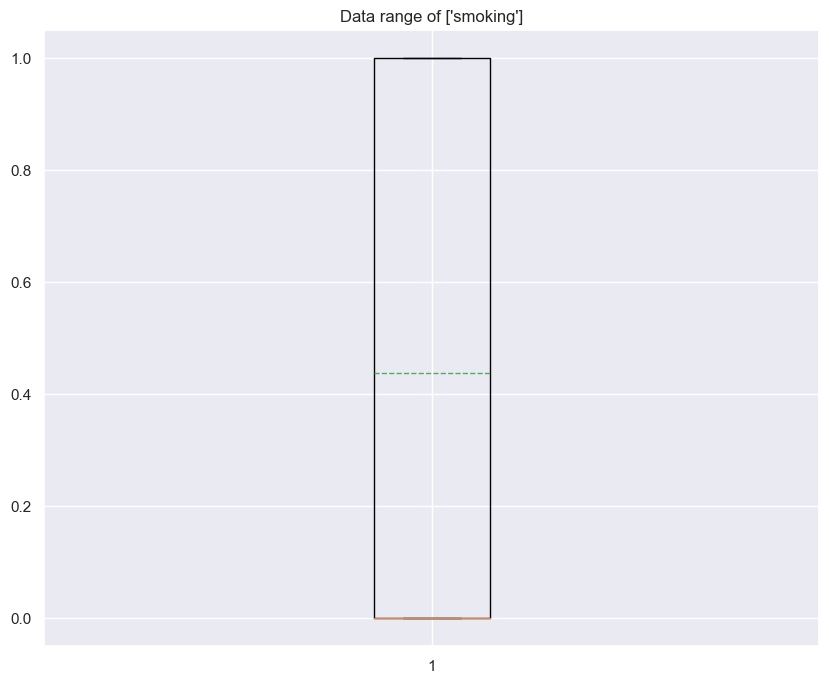

In [ ]:
# データの範囲を調べる
plt.figure(figsize=(10, 8))
plt.boxplot(target, showmeans=True, meanline=True)
plt.title('Data range of ' + target_name)
plt.grid(True)

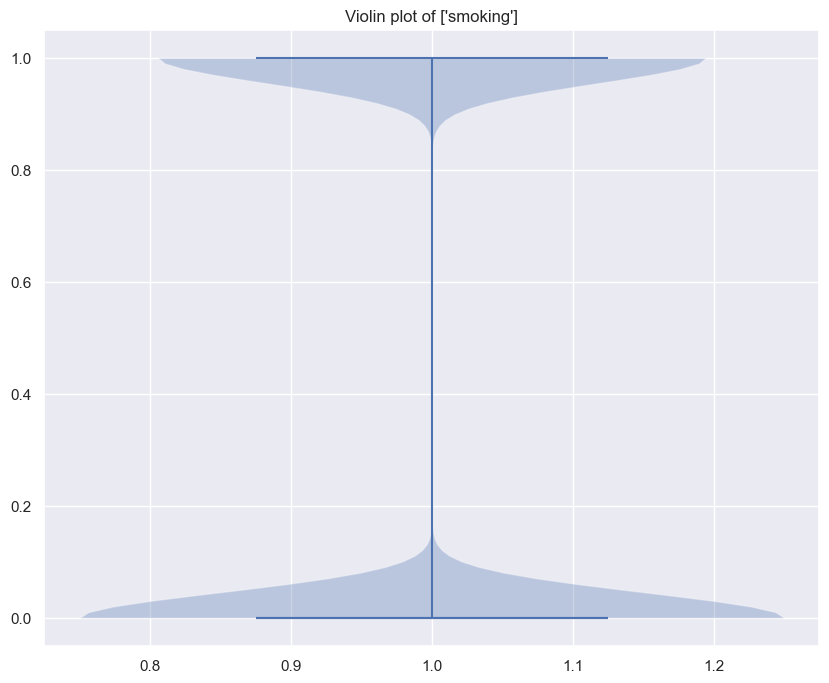

In [ ]:
# バイオリンプロット
plt.figure(figsize=(10, 8))
plt.violinplot(target, showmedians=True) # 中央値をマーキングする
plt.title('Violin plot of ' + target_name)
plt.grid(True)

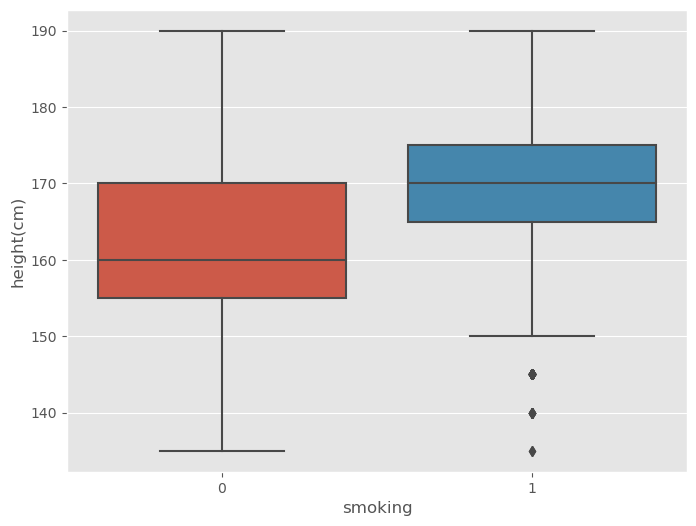

In [ ]:
# 目的変数と'height(cm)'（最も特徴重要度の高い説明変数）との関係
train_height = 'height(cm)'
categorical_variate_corr = pd.concat([target, train[train_height]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=target, y=train_height, data=categorical_variate_corr)
fig.axis();

### 特徴量の重要度評価

CPU times: user 4min 27s, sys: 5.2 s, total: 4min 32s
Wall time: 7min 2s


<Axes: >

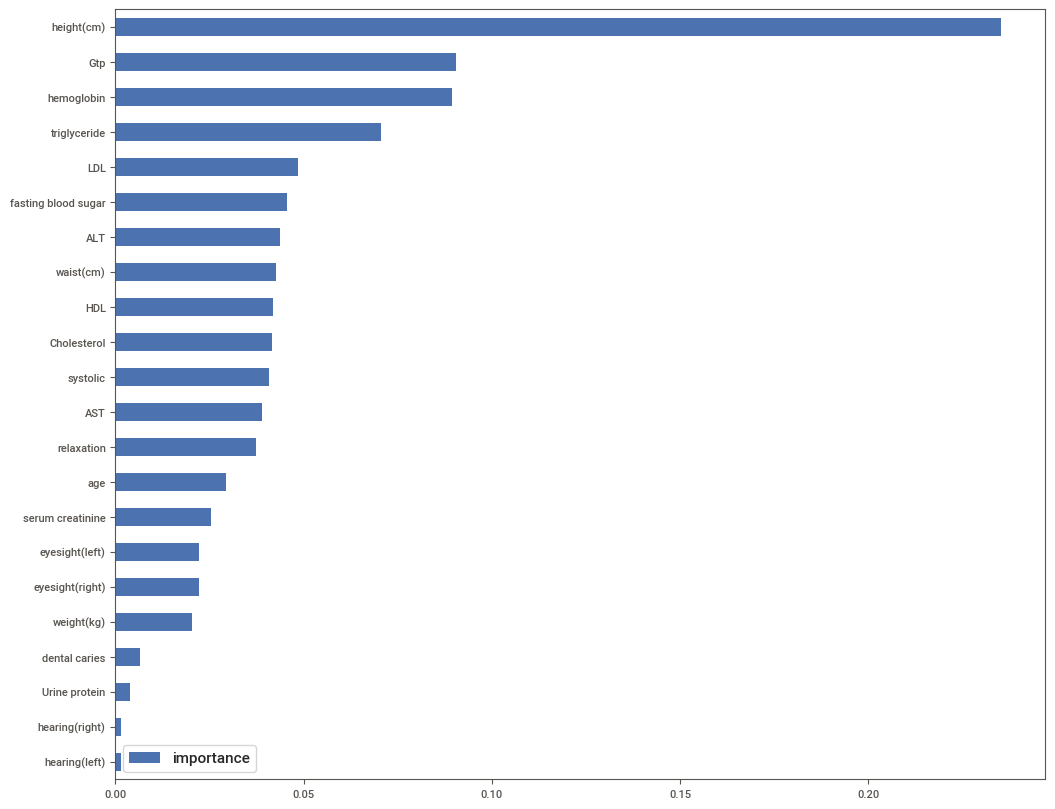

In [ ]:
%%time

best_forest = RandomForestRegressor(
    random_state=42,
)

best_forest.fit(X, y)
importance = best_forest.feature_importances_

feature_importance = pd.DataFrame(data=importance, index=X.columns, columns=['importance']) \
    .sort_values(ascending=True, by='importance')

feature_importance.plot(kind='barh', figsize=(12, 8), color='b')

* 'height(cm)'が重要度が特に高い
* 'hearing(right, left)'が低い

### 相関（ヒートマップ）

<Axes: >

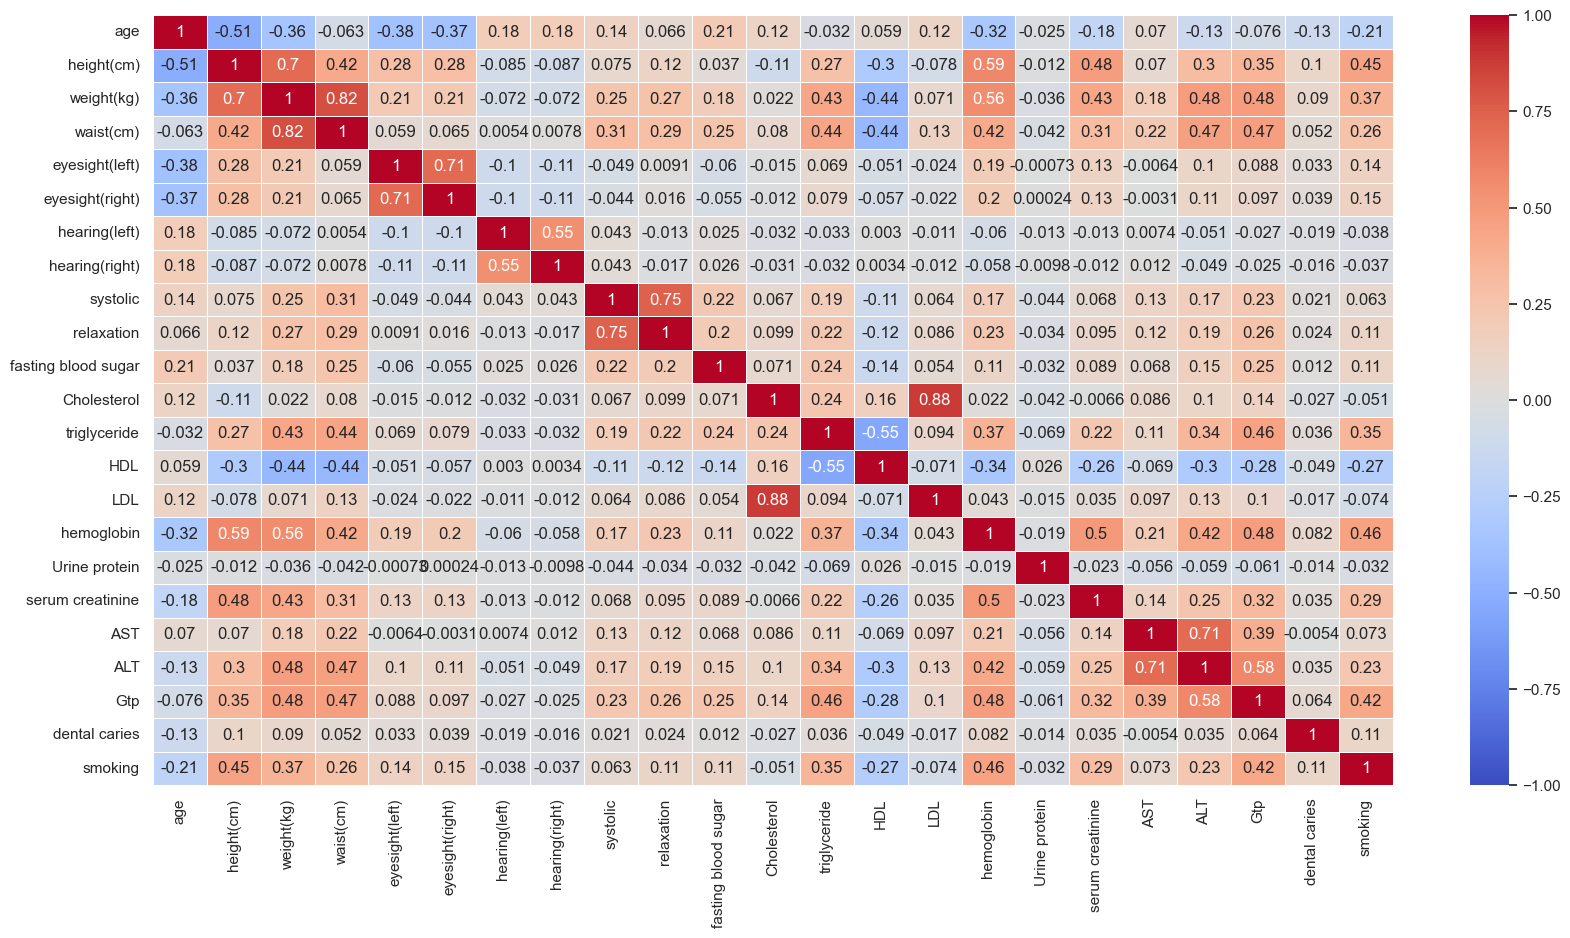

In [ ]:
corr = train.corr(method='spearman')
plt.figure(figsize=(20, 10))
sns.heatmap(corr, linewidth=0.5, square=False, annot=True, cmap="coolwarm", vmin=-1, vmax=1)

In [ ]:
# 対数変換後の相関係数
correlation = X.corr()
correlation.style.background_gradient(cmap='coolwarm')

* 'waist(cm)'と'weight(kg)'の間には強い負の相関がある（83%の相関）
    - 対数変換後は正の相関があるが、対数変換前は負の相関だった

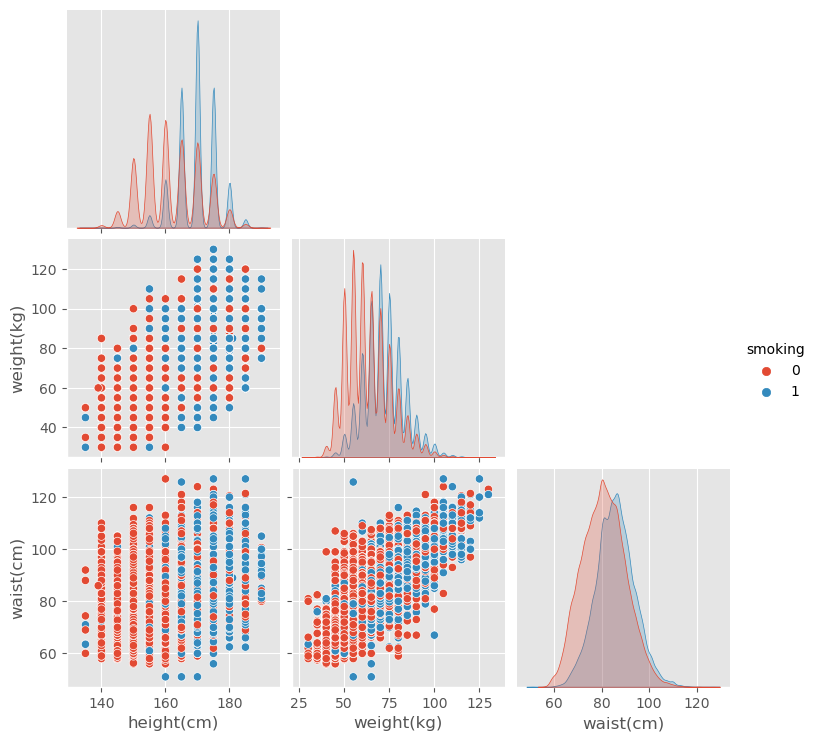

In [ ]:
# 'height(cm)', 'weight(kg)', 'waist(cm)'とsmoking(目的変数)との相関関係を調べる
sns.pairplot(data=train[['height(cm)', 'weight(kg)', 'waist(cm)', 'smoking']], hue='smoking', corner=True);

- 身長が高い人（体重も重い傾向があります）は喫煙する傾向がある
- 体重（kg）とウエスト（cm）の関係はほぼ直線的

#### 相関(目的変数)

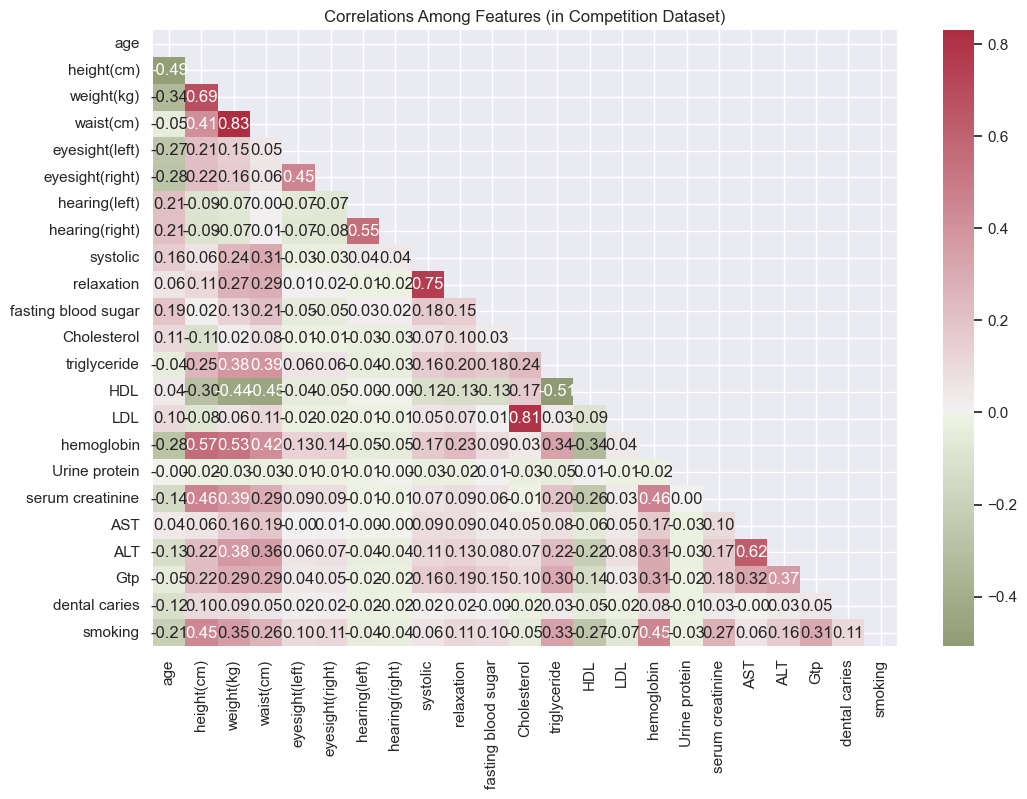

In [ ]:
corr_mat_data = train.corr()
data_mask = np.triu(np.ones_like(corr_mat_data, dtype=bool))

cmap = sns.diverging_palette(100, 7, s=75, l=40, n=5, center='light', as_cmap=True)

plt.figure(figsize=(12, 8))
sns.heatmap(corr_mat_data, annot=True, cmap=cmap, fmt='.2f', center=0,
            annot_kws={'size': 12}, mask=data_mask).set_title('Correlations Among Features (in Competition Dataset)');

* 'LDL' と 'Cholesterol'は81％の相関
* 'relaxation' は 'systolic'との間で強い相関がある（75%の相関）
* 'HDL' が 'triglyceride' との間で最も高い負相関を持つ

In [ ]:
# 目的変数との相関の値が高い順に表示する
corr_target_data = train.corr()['smoking'] # 目的変数を指定する
corr_target_data.sort_values(ascending=False)

smoking                1.000000
hemoglobin             0.450679
height(cm)             0.447111
weight(kg)             0.351748
triglyceride           0.331975
Gtp                    0.305561
serum creatinine       0.272979
waist(cm)              0.262715
ALT                    0.163016
eyesight(right)        0.109781
relaxation             0.109501
dental caries          0.106636
eyesight(left)         0.100420
fasting blood sugar    0.096534
AST                    0.059394
systolic               0.058642
Urine protein         -0.028548
hearing(right)        -0.036858
hearing(left)         -0.038219
Cholesterol           -0.051896
LDL                   -0.072285
age                   -0.206033
HDL                   -0.271186
Name: smoking, dtype: float64

#### 散布図

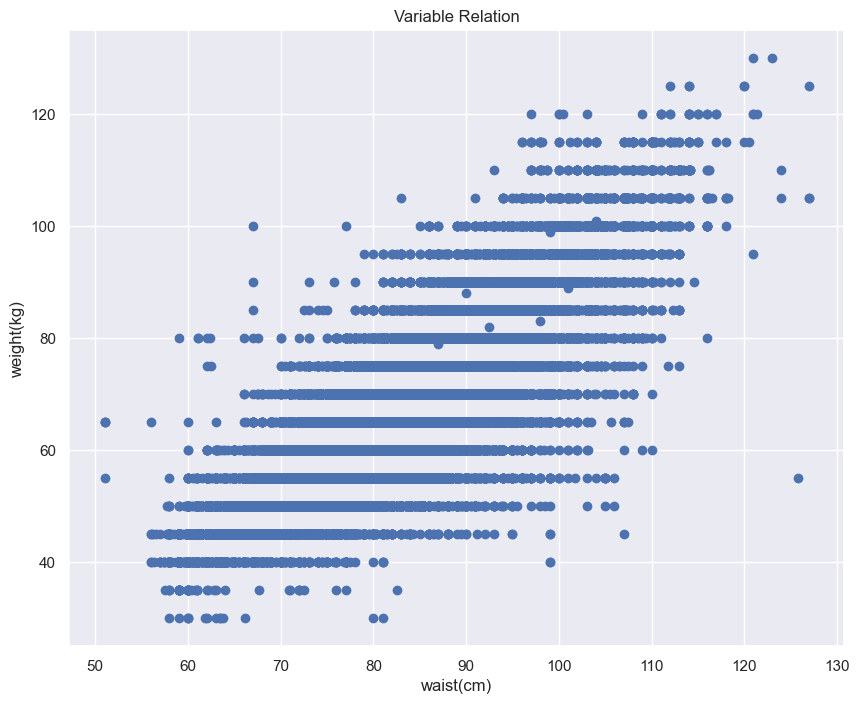

In [ ]:
# ヒートマップの結果から、散布図で変数の関係性を調べる
train_waist = train['waist(cm)']
train_weight = train['weight(kg)']

plt.figure(figsize=(10, 8))

plt.scatter(train_waist, train_weight)
plt.title('Variable Relation')
plt.xlabel('waist(cm)')
plt.ylabel('weight(kg)')
plt.grid(True)

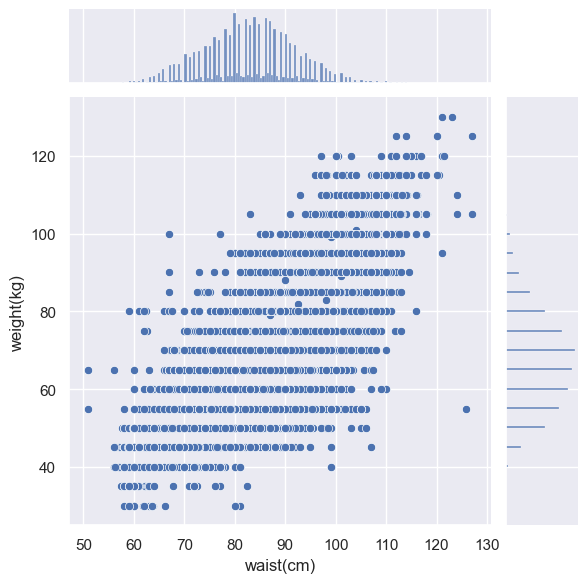

In [ ]:
# 二変量グラフと単変量グラフを作成する
sns.jointplot(x=train_waist, y=train_weight, data=train)

#### 高い相関を持つ説明変数の散布図

ここは修正が必要

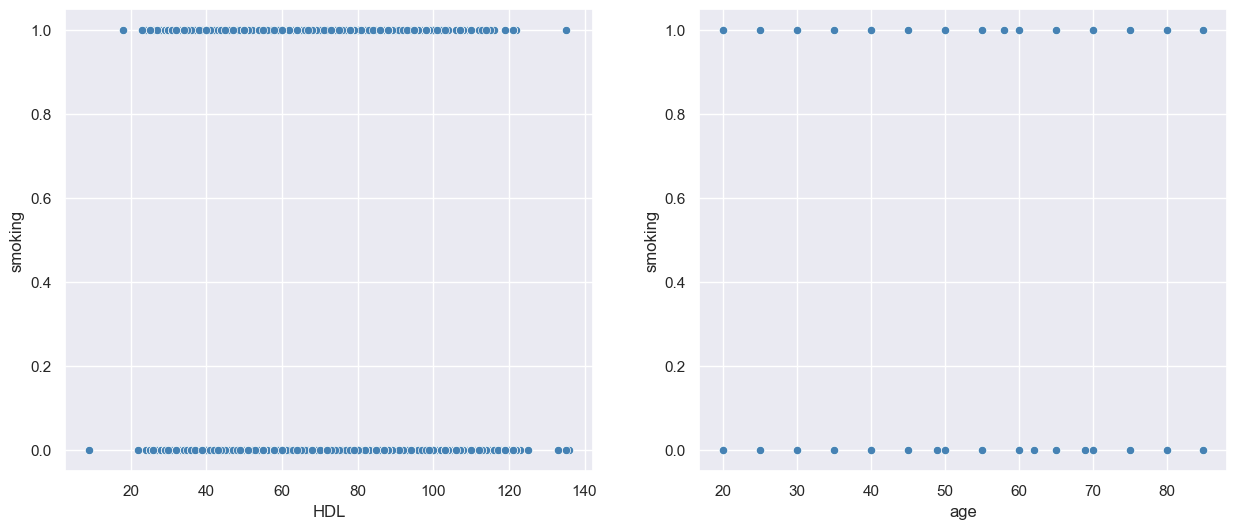

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(ax=axes[0], data=train, x='HDL', y='smoking', color='steelblue')
sns.scatterplot(ax=axes[1], data=train, x='age', y='smoking', color='steelblue');

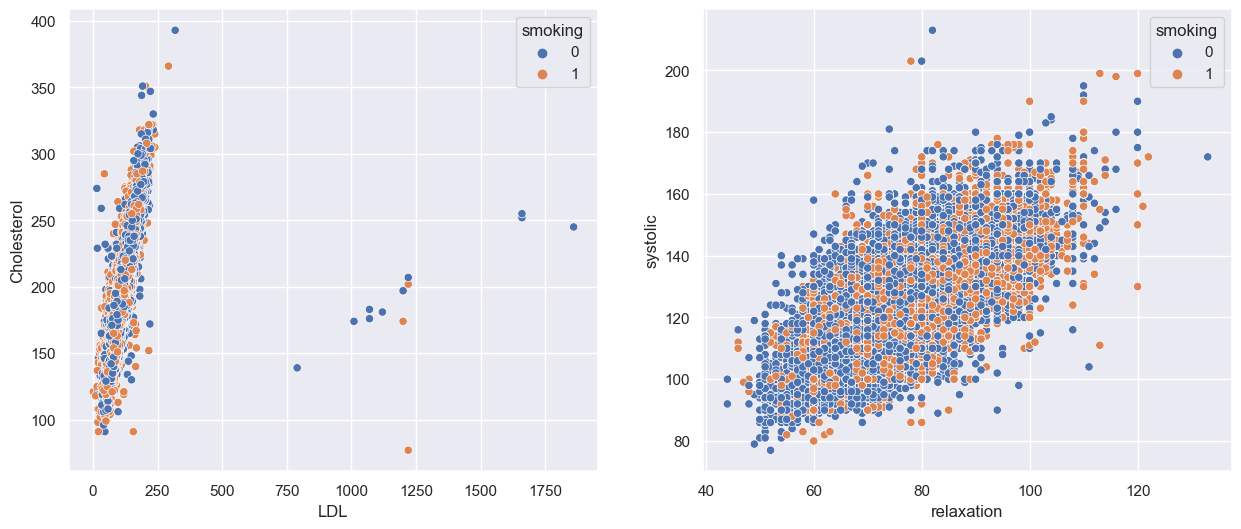

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

sns.scatterplot(ax=axes[0], data=train, x='LDL', y='Cholesterol', hue='smoking')
sns.scatterplot(ax=axes[1], data=train, x='relaxation', y='systolic', hue='smoking');

## 目的変数

In [ ]:
# 目的変数（smoking）を数える
print(f'{target.value_counts()}\n\n')
print('値の相対的な出現頻度')
print(target.value_counts() / train.shape[0]) # 値の相対的な出現頻度

smoking
0    89603
1    69653
Name: count, dtype: int64


値の相対的な出現頻度
smoking
0    0.562635
1    0.437365
Name: count, dtype: float64


In [ ]:
train.groupby('smoking')['height(cm)'].mean() # smoking(目的変数)を軸として、'height(cm)'の平均値を算出する

smoking
0    161.790442
1    169.739150
Name: height(cm), dtype: float64

### データの抽出

In [ ]:
train[train['smoking'] == 1.0] # 条件（フィルター）

age  height(cm)  weight(kg)  waist(cm)  eyesight(left)  \
0        55         165          60       81.0             0.5   
2        20         170          75       81.0             0.4   
4        30         165          60       80.5             1.5   
5        50         170          55       51.0             1.2   
8        40         165          70       89.0             0.7   
...     ...         ...         ...        ...             ...   
159242   60         170          70       83.0             0.6   
159244   40         170          85       99.0             0.9   
159245   35         175          80       87.2             0.7   
159249   40         170          85       91.4             1.2   
159254   50         165          75       92.0             1.2   

        eyesight(right)  hearing(left)  hearing(right)  systolic  relaxation  \
0                   0.6              1               1       135          87   
2                   0.5              1               1       118          75   
4                   1.0              1               1       121          76   
5                   1.2              1               1       146          95   
8                   1.0              1               1       130          80   
...                 ...            ...             ...       ...         ...   
159242              0.8              1               1       134          85   
159244              0.7              1               1       137          90   
159245              0.7              1               1       110          70   
159249              0.9              1               1       110          68   
159254              1.0              1               1       121          90   

        fasting blood sugar  Cholesterol  triglyceride  HDL  LDL  hemoglobin  \
0                        94          172           300   40   75        16.5   
2                        79          178           197   45   93        17.4   
4                        91          155            87   44   93        15.4   
5                       101          199           343   31   99        15.9   
8                       104          243           163   59  150        15.7   
...                     ...          ...           ...  ...  ...         ...   
159242                   96          151            79   40   95        15.3   
159244                   84          163           181   34   94        15.0   
159245                  105          255           325   44  150        15.7   
159249                   91          220           248   45  125        16.1   
159254                  122          165           148   55   80        14.4   

        Urine protein  serum creatinine  AST  ALT  Gtp  dental caries  smoking  
0                   1               1.0   22   25   27              0        1  
2                   1               0.8   27   31   53              0        1  
4                   1               0.8   19   13   17              0        1  
5                   1               0.7   24   42  119              1        1  
8                   1               0.9   24   21   31              0        1  
...               ...               ...  ...  ...  ...            ...      ...  
159242              1               1.0   21   17   17              0        1  
159244              1               1.0   33   24   62              0        1  
159245              1               1.0   23   41   26              1        1  
159249              1               0.9   26   44   37              0        1  
159254              1               1.1   22   17   37              0        1  

[69653 rows x 23 columns]

### 説明変数と目的変数の喫煙率を調べる(0=No, 1=Yes)

In [ ]:
# eyesight(left, right)とsmoking(目的変数)との関係
pd.crosstab(train['eyesight(left)'], target, normalize='index')

smoking                0         1
eyesight(left)                    
0.1             0.669014  0.330986
0.2             0.694143  0.305857
0.3             0.703356  0.296644
0.4             0.707522  0.292478
0.5             0.665833  0.334167
0.6             0.671148  0.328852
0.7             0.640735  0.359265
0.8             0.622629  0.377371
0.9             0.585788  0.414212
1.0             0.548020  0.451980
1.1             0.000000  1.000000
1.2             0.514283  0.485717
1.3             0.666667  0.333333
1.5             0.460510  0.539490
1.6             0.473684  0.526316
1.7             0.000000  1.000000
1.8             0.000000  1.000000
1.9             1.000000  0.000000
2.0             0.412926  0.587074
9.9             0.674242  0.325758

In [ ]:
pd.crosstab(train['eyesight(right)'], target, normalize='index')

smoking                 0         1
eyesight(right)                    
0.1              0.704857  0.295143
0.2              0.694311  0.305689
0.3              0.716919  0.283081
0.4              0.700000  0.300000
0.5              0.678143  0.321857
0.6              0.690966  0.309034
0.7              0.652750  0.347250
0.8              0.637278  0.362722
0.9              0.568484  0.431516
1.0              0.543405  0.456595
1.2              0.508732  0.491268
1.3              0.666667  0.333333
1.4              0.500000  0.500000
1.5              0.455629  0.544371
1.6              0.315789  0.684211
2.0              0.481343  0.518657
9.9              0.692308  0.307692

- 9.9は他の値と非常に異なる
- データ数の少ない値が存在する（9.9、1.6、1.3、1.8、1.9、1.1、1.7）。

In [ ]:
# hearing(left, right)とsmoking(目的変数)との関係
pd.crosstab(train['hearing(left)'], target, normalize='index')

smoking               0         1
hearing(left)                    
1              0.559664  0.440336
2              0.683604  0.316396

In [ ]:
pd.crosstab(train['hearing(right)'], target, normalize='index')

smoking                0         1
hearing(right)                    
1               0.559804  0.440196
2               0.680697  0.319303

- 聴力が1の場合、約56%が（右または左に関わらず）非喫煙者
- 聴力が2の場合、約68%が（右または左に関わらず）非喫煙者

In [ ]:
# 'Urine protein'(尿蛋白)と'smoking'(目的変数)との関係
pd.crosstab(train['Urine protein'], target)

smoking            0      1
Urine protein              
1              84311  66551
2               3549   2060
3               1402    826
4                287    190
5                 48     26
6                  6      0

Urine protein = 6の観測値が6つしかない

In [ ]:
# 'serum creatinine'(血清クレアチニン)と'smoking'(目的変数)との関係
pd.crosstab(train['serum creatinine'], target)

smoking               0      1
serum creatinine              
0.1                   4     13
0.2                   3      0
0.3                   4      1
0.4                 298     13
0.5                2444    180
0.6               10161    992
0.7               15583   4199
0.8               18540  11262
0.9               16637  19139
1.0               13442  17871
1.1                7295  10535
1.2                3579   4078
1.3                1076   1047
1.4                 375    229
1.5                  85     52
1.6                  31     27
1.7                   8      3
1.8                  10      5
1.9                   8      4
2.0                   7      0
2.1                   4      0
2.2                   2      1
2.5                   2      1
3.0                   0      1
3.4                   1      0
5.9                   2      0
7.4                   1      0
9.9                   1      0

他の値とは異なるいくつかの血清クレアチニンの値がある（5.9、7.4、および9.9）

In [ ]:
# 'serum creatinine'(歯周病)と'smoking'(目的変数)との関係
pd.crosstab(train['dental caries'], target, normalize='index')

smoking               0         1
dental caries                    
0              0.588918  0.411082
1              0.456172  0.543828

- 'dental caries'=0(歯周病なし)の場合、喫煙者である可能性は約41%
- 'dental caries'=1(歯周病あり)の場合、喫煙者である可能性は約54%

- 一部の特徴量は喫煙とより明確な関係がある（身長、トリグリセリド、ヘモグロビンなど

メモ
* **得られた情報**
    - 概要
			- 評価指標
    - データの構成
    - データ数・型
    - カラム名・数
- EDA
    - 要約統計量
    - 欠損値
    - 尖度・歪度
    - 分布
        - 密度関数(ヒストグラム)
            - 対数変換したデータ
        - 円グラフ
        - 箱ひげ図
        - 特徴量の重要度評価
        - 相関（ヒートマップ）
				- 散布図
    - 目的変数
		- EDAの可視化するためのライブラリ

## EDAの可視化するためのライブラリ

今後はsweetvizのみで出力する

### sweetviz

In [ ]:
report = sv.compare([train, "Train"], [test, "Test"], target_feat='smoking')
report.show_html(OUTPUT_DIR + "/EDA_sweetviz.html")

                                             |          | [  0%]   00:00 -> (? left)

Report /Users/ootsuka/Desktop/プログラミング/Kaggle/生体信号を使用した喫煙者の状態のバイナリ予測/output//EDA_sweetviz.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


0:108: execution error: ファイル“不特定のオブジェクト”が見つかりませんでした。 (-43)


## 実行時間を調べるために使う

In [ ]:
end_time = time.time()
lap = end_time - start_time
indi_time = changeHMS(lap)
indi_time

'5m15s'

実行時間 12m45s